In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple
from datetime import datetime
import re 
from enum import IntEnum
#import seaborn as sns
import os
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from itertools import groupby
from operator import itemgetter

In [2]:
# # experiment computer has locale set to german -_-
import locale
import contextlib
@contextlib.contextmanager
def setlocale(*args, **kw):
    saved = locale.setlocale(locale.LC_ALL)
    yield locale.setlocale(*args, **kw)
    locale.setlocale(locale.LC_ALL, saved)

PIX_PER_MM = 38.773681409813456
CAM_WIDTH = 2048
CAM_HEIGHT = 2048

def parse_filename(filename: str, loc: str = 'de_DE.utf8') -> Tuple:

    regexp = re.compile(r"""
        (?P<fish_id>\d+)_
        (?P<dpf>\d+)dpf_
        (?P<datetime>\w+).csv
        """, re.VERBOSE)

    match = regexp.fullmatch(filename)
    if match is None:
        raise RuntimeError(f'Wrong filename format, {filename}')
    
    fish_id = int(match.group('fish_id'))
    dpf = int(match.group('dpf'))
    
    with setlocale(locale.LC_ALL, loc):
        date = datetime.strptime(match.group('datetime'),'%a_%d_%b_%Y_%Hh%Mmin%Ssec')
    
    return (fish_id, dpf, date)

def get_relative_time(data):
    return data['t_local'] - data['t_local'].iloc[0]

def get_relative_index(data):
    return data.index - data.index[0]

def get_heading_angle(data):
    angle = np.arctan2(data['pc1_y'],data['pc1_x'])
    notna = ~np.isnan(angle)
    angle_unwrapped = np.zeros_like(angle) * np.nan
    angle_unwrapped[notna] = np.unwrap(angle[notna]) # TODO this is probably a bit wrong
    return angle, angle_unwrapped

def get_cumulative_distance(data):
    x_diff = data['centroid_x'].diff()
    y_diff = data['centroid_y'].diff()
    frame_distances = np.sqrt(x_diff**2 + y_diff**2) * 1/PIX_PER_MM
    return frame_distances.cumsum()  # This gives total distance traveled over time

def get_displacement(data):
    x_displacement = (data['centroid_x'] - data['centroid_x'].iloc[0]) * 1/PIX_PER_MM
    y_displacement = (data['centroid_y'] - data['centroid_y'].iloc[0]) * 1/PIX_PER_MM
    return np.sqrt(x_displacement**2 + y_displacement**2)

class StimType(IntEnum):
    DARK = 0
    BRIGHT = 1
    PHOTOTAXIS = 2
    OMR = 3
    OKR = 4
    LOOMING = 5

def get_cumulative_speed(data):
    # For frame-to-frame calculations, each time step is 1 unit
    x_diff = data['centroid_x'].diff()
    y_diff = data['centroid_y'].diff()
    frame_distances = np.sqrt(x_diff**2 + y_diff**2) * 1/PIX_PER_MM
    speed = frame_distances/ get_relative_time(data).diff()  # distance per frame
    return speed


In [20]:
def smooth_data(speed_data, method='gaussian', **kwargs):
    # Convert to pandas Series if not already
    data = pd.Series(speed_data)
    
    if method == 'gaussian':
        # Default parameters
        sigma = kwargs.get('sigma', 2)
        
        # Create a copy to avoid modifying the original
        smoothed = data.copy()
    
        # Apply Gaussian filter to data and mask
        smoothed = gaussian_filter1d(data.values, sigma=sigma)
        
    elif method == 'moving_avg':
        # Default parameters
        window = kwargs.get('window', 15)
        min_periods = kwargs.get('min_periods', 1)
        
        # Apply rolling window average
        smoothed = data.rolling(
            window=window, 
            center=True, 
            min_periods=min_periods
        ).mean()
        
    elif method == 'ewm':
        # Default parameters
        span = kwargs.get('span', 10)
        min_periods = kwargs.get('min_periods', 1)
        
        # Apply exponentially weighted moving average
        smoothed = data.ewm(
            span=span, 
            min_periods=min_periods
        ).mean()
    
    else:
        raise ValueError(f"Unknown smoothing method: {method}")
        
    return smoothed
def detect_fish_bouts_2(data, fish_id=None, method='gaussian', **kwargs):
    """
    Process fish movement data to detect swimming bouts
    
    Parameters:
    - data: DataFrame containing fish movement data
    - fish_id: Optional ID for the fish (for plot titles)
    - method: Smoothing method to use ('gaussian', 'moving_avg', 'ewm')
    - kwargs: Additional parameters for the smoothing method
    
    Returns:
    - DataFrame containing bout information
    """
    # Make a copy to avoid modifying the original data
    df = data.copy()
    
    smoothed_speed = smooth_data(df['speed'], method=method, **kwargs)
    df['smoothed_speed'] = smoothed_speed
    
    # Calculate threshold for bout detection
    mean_speed = np.mean(smoothed_speed)
    std_speed = np.std(smoothed_speed)
    threshold = mean_speed + 2 * std_speed
    
    # Find peaks in the smoothed data (potential bout centers)
    peaks, peak_properties = find_peaks(
        smoothed_speed, 
        height=threshold,
        distance=10,  # Minimum samples between peaks
        prominence=0.5 * std_speed  # Minimum prominence to be considered a peak
    )
    
    # Find regions where speed exceeds threshold (bout regions)
    bout_indices = np.where(smoothed_speed > threshold)[0]
    
    # Group consecutive indices to identify complete bouts
    bout_groups = []
    for k, g in groupby(enumerate(bout_indices), lambda x: x[0] - x[1]):
        group = list(map(itemgetter(1), g))
        if len(group) > 3:  # Minimum number of frames to be considered a bout
            bout_groups.append((group[0], group[-1]))
    
    # Track the number of bouts detected
    num_bouts_detected = len(bout_groups)
    # Create a DataFrame to store bout information
    bout_info = []
    for i, (start_idx, end_idx) in enumerate(bout_groups):
        # Find the peak within this bout
        bout_peaks = [p for p in peaks if start_idx <= p <= end_idx]
        
        if bout_peaks:
            peak_idx = bout_peaks[np.argmax(smoothed_speed[bout_peaks])]
            peak_speed = smoothed_speed[peak_idx]
            
            # Calculate angle change
            angle_before_bout = np.unwrap(df['angle'].iloc[max(0, start_idx-1):start_idx+1])
            angle_after_bout = np.unwrap(df['angle'].iloc[end_idx:end_idx+2])
            angle_change = angle_after_bout[-1] - angle_before_bout[0]

            # Calculate mean distance traveled during the bout
            distance_during_bout = df['distance'].iloc[start_idx:end_idx+1].mean()
            
            #number of bouts detected

            # Calculate bout properties
            bout_info.append({
                'fish_id': fish_id,
                'bout_id': i+1,
                'start_idx': start_idx,
                'peak_idx': peak_idx,
                'end_idx': end_idx,
                'start_time': df['relative_time'].iloc[start_idx],
                'peak_time': df['relative_time'].iloc[peak_idx],
                'end_time': df['relative_time'].iloc[end_idx],
                'duration': df['relative_time'].iloc[end_idx] - df['relative_time'].iloc[start_idx],
                'peak_speed': peak_speed,
                'mean_speed': np.mean(smoothed_speed[start_idx:end_idx+1]),
                'angle_change': angle_change,
                'distance_during_bout': distance_during_bout,  # distance traveled during the bout
                'num_bouts_detected': num_bouts_detected
            })
    
    bout_df = pd.DataFrame(bout_info)
    
    # Calculate inter-bout intervals
    bout_df['inter_bout_interval'] = bout_df['start_time'].diff().shift(-1)
    
    return bout_df  

def plot_bout_detection(df, bout_df, fish_id):
    """
    Create plots to visualize the bout detection process
    
    Parameters:
    - df: DataFrame containing the processed data
    - bout_df: DataFrame containing bout information
    - fish_id: ID for the fish (for plot titles)
    """
    smoothed_speed = df['smoothed_speed']
    threshold = np.mean(smoothed_speed) + 2 * np.std(smoothed_speed)
    peaks = bout_df['peak_idx'].values
    bout_groups = bout_df[['start_idx', 'end_idx']].values
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Plot 1: Original vs Smoothed Speed
    ax1.plot(df['relative_time'], df['speed'], 'b-', alpha=0.5, label='Raw Speed')
    ax1.plot(df['relative_time'], smoothed_speed, 'g-', linewidth=2, label='Smoothed Speed')
    ax1.axhline(y=threshold, color='r', linestyle='--', alpha=0.7, label=f'Threshold ({threshold:.2f})')
    ax1.set_ylabel('Speed (mm/sec)')
    ax1.set_title(f'Original vs Smoothed Speed for Fish ID: {fish_id}')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Plot 2: Detected Bouts
    ax2.plot(df['relative_time'], smoothed_speed, 'g-', label='Smoothed Speed')
    ax2.axhline(y=threshold, color='r', linestyle='--', alpha=0.7, label=f'Threshold ({threshold:.2f})')
    
    # Highlight bout regions
    for start_idx, end_idx in bout_groups:
        start_time = df['relative_time'].iloc[start_idx]
        end_time = df['relative_time'].iloc[end_idx]
        ax2.axvspan(start_time, end_time, alpha=0.2, color='orange')
    
    # Mark peak points
    peak_times = df['relative_time'].iloc[peaks]
    peak_speeds = smoothed_speed.iloc[peaks]
    ax2.scatter(peak_times, peak_speeds, color='red', s=50, zorder=5, label='Bout Peaks')
    
    ax2.set_xlabel('Relative Time')
    ax2.set_ylabel('Speed (mm/sec)')
    ax2.set_title(f'Detected Swimming Bouts for Fish ID: {fish_id}')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    return fig

def print_bout_statistics(bout_df, fish_id):
    # ...existing code...
    
    if len(bout_df) > 0:
        print(f"Total Number of bouts detected: {bout_df['num_bouts_detected'].iloc[0]}")
        print(f"Average bout duration: {bout_df['duration'].mean():.2f} time units")
        print(f"Average bout peak speed: {bout_df['peak_speed'].mean():.2f} mm/sec")
        print(f"Average bout mean speed: {bout_df['mean_speed'].mean():.2f} mm/sec")
        print(f"Average inter-bout interval: {bout_df['inter_bout_interval'].mean():.2f} time units")
        print(f"Average angle change: {bout_df['angle_change'].mean():.2f} radians")
        print(f"Average distance traveled: {bout_df['distance_during_bout'].mean():.2f} mm") 
        print("\nTop 5 bouts by peak speed:")
        print(bout_df.sort_values('peak_speed', ascending=False).head(5)[['bout_id', 'start_time', 'duration', 'peak_speed']])

def plot_histograms(bout_df):
    """
    Plot histograms of bout duration, inter-bout intervals (log-normal scale), and angle change.
    
    Parameters:
    - bout_df: DataFrame containing bout information
    """
    plt.figure(figsize=(20, 5))
    
    # Plot histogram of bout duration
    plt.subplot(1, 3, 1)
    plt.hist(bout_df['duration'], bins=20, color='blue', alpha=0.7)
    plt.title('Bout Duration')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Frequency')
    
    
    # Plot histogram of inter-bout intervals (log-transformed but displayed in original units)
    plt.subplot(1, 3, 2)
    log_intervals = bout_df['log_inter_bout_interval'].dropna()  # Use the precomputed log-transformed column
    plt.hist(log_intervals, bins=20, color='green', alpha=0.7)
    
    # Adjust x-axis ticks to show original units
    original_ticks = np.exp(plt.xticks()[0])  # Convert log-transformed ticks back to original scale
    plt.xticks(np.log(original_ticks), [f"{tick:.2f}" for tick in original_ticks])  # Set ticks and labels
    
    plt.title('Inter-Bout Intervals (Log-Transformed)')
    plt.xlabel('Interval (seconds)')
    plt.ylabel('Frequency')
    
    # Plot histogram of angle change
    plt.subplot(1, 3, 3)
    plt.hist(bout_df['angle_change'], bins=20, color='red', alpha=0.7)
    plt.title('Angle Change')
    plt.xlabel('Angle Change (radians)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

    # Plot histogram of distance traveled
    plt.subplot(2, 2, 4)
    plt.hist(bout_df['distance_during_bout'], bins=20, color='purple', alpha=0.7)
    plt.title('Distance Traveled During Bouts')
    plt.xlabel('Distance (mm)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

    # Plot histogram of mean speed during bouts
    plt.subplot(2, 3, 5)
    plt.hist(bout_df['mean_speed'], bins=20, color='orange', alpha=0.7)
    plt.title('Mean Speed During Bouts')
    plt.xlabel('Speed (mm/sec)')
    plt.ylabel('Frequency')
    
    # Plot histogram of peak speed during bouts
    plt.subplot(2, 3, 6)
    plt.hist(bout_df['peak_speed'], bins=20, color='cyan', alpha=0.7)
    plt.title('Peak Speed During Bouts')
    plt.xlabel('Speed (mm/sec)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

In [ ]:
import os

#read the files, make separate dataframes by grouping the StimType, and add the parsed columns to it
#use the get_relative_time , get_relative_index, get_heading_angle, get_distance functions
#Plot the centroids
#plot the heading_angle
#calculate the speed


DATA_FOLDER = r".\Modelling_data\Cichlids"

DATAFILES = [
    '08_10dpf_Mi_28_Aug_2024_10h18min41sec.csv',
    '09_10dpf_Mi_28_Aug_2024_11h44min03sec.csv',
    '10_10dpf_Mi_28_Aug_2024_13h16min25sec.csv',
    '11_10dpf_Mi_28_Aug_2024_14h30min41sec.csv',
    '12_10dpf_Mi_28_Aug_2024_16h21min17sec.csv',
    '13_10dpf_Mi_28_Aug_2024_17h41min49sec.csv', 
    '02_10dpf_So_01_Sep_2024_11h51min15sec.csv',
    '03_10dpf_So_01_Sep_2024_14h42min31sec.csv',
    '04_10dpf_So_01_Sep_2024_16h12min08sec.csv',
    #'05_10dpf_So_01_Sep_2024_17h42min55sec.csv',
    '06_10dpf_So_01_Sep_2024_19h13min20sec.csv',
    '07_10dpf_So_01_Sep_2024_20h44min18sec.csv',
    '14_10dpf_Mo_09_Sep_2024_12h17min25sec.csv',
    '15_10dpf_Mo_09_Sep_2024_13h49min54sec.csv',
    '16_10dpf_Mo_09_Sep_2024_15h24min48sec.csv',
    '17_10dpf_Mo_09_Sep_2024_18h07min58sec.csv',
    '18_10dpf_Fr_20_Sep_2024_10h39min51sec.csv',
    '19_10dpf_Fr_20_Sep_2024_12h14min45sec.csv',
    '20_10dpf_Fr_20_Sep_2024_13h51min56sec.csv',
    '21_10dpf_Fr_20_Sep_2024_15h23min51sec.csv',
    '22_10dpf_Fr_20_Sep_2024_16h59min47sec.csv',
    '23_10dpf_Fr_20_Sep_2024_18h29min15sec.csv',
    '24_10dpf_Fr_20_Sep_2024_20h02min20sec.csv'

]


# Initialize dictionaries for specific stimulus types
target_stims = [StimType.DARK, StimType.BRIGHT, StimType.PHOTOTAXIS]
stim_dataframes = {stim: pd.DataFrame() for stim in target_stims}

for file in DATAFILES:
    fish_id, dpf, date = parse_filename(file)
    
    # Read and preprocess data
    data = pd.read_csv(os.path.join(DATA_FOLDER, file))
    data_filtered = data.groupby('image_index').first()
    data_filtered = data_filtered[1:]
    data_filtered['stim_id'] = data_filtered['stim_id'].astype(int)
    
    # Remove columns with "tail_point" in the name
    data_filtered = data_filtered.loc[:, ~data_filtered.columns.str.contains("tail_point")]
    
    # Add parsed metadata to each row
    data_filtered['fish_id'] = fish_id
    data_filtered['dpf'] = dpf
    data_filtered['date'] = date
    
    # Group by specific stimulus types and concatenate
    for stim in target_stims:
         stim_data = data_filtered[data_filtered['stim_id'] == stim.value]
         stim_dataframes[stim] = pd.concat([stim_dataframes[stim], stim_data])

# Optional: Save each stimulus type DataFrame
# Ensure the processed_data folder exism, df in stim_dataframes.items():
    if not data_filtered.empty:
        # Append the date to the filename
        date_str = datetime.now().strftime('%Y%m%d')
        filename = f'{stim.name.lower()}_data_{date_str}.csv'
        filepath = os.path.join(r'.\processed_data', filename)
        
        # Check if the file already exists
        if not os.path.exists(filepath):
            data_filtered.to_csv(filepath, index=False)


In [22]:
bright_df = pd.read_csv(r'.\processed_data\bright_data_20250409.csv')

# Calculate derived metrics for all fish
derived_metrics_list = []

# Group by fish_id
grouped_df = bright_df.groupby('fish_id')
for fish_id, group in grouped_df:
    # Calculate derived metrics
    group['relative_time'] = get_relative_time(group)
    group['relative_index'] = get_relative_index(group)
    group['distance'] = get_cumulative_distance(group)
    group['angle'], group['unwrapped_angle'] = get_heading_angle(group)
    group['speed'] = get_cumulative_speed(group)
    # Calculate smoothed speed
    group['smoothed_speed'] = smooth_data(group['speed'], method='gaussian', sigma=2)
    # Append the processed group to the list
    derived_metrics_list.append(group)

# Combine all derived metrics into a single DataFrame
derived_metrics_df = pd.concat(derived_metrics_list, ignore_index=True)

# Save the derived metrics DataFrame to a CSV file
date_str = datetime.now().strftime('%Y%m%d')
derived_metrics_path = rf'.\processed_data\derived_metrics_bright_{date_str}.csv'
derived_metrics_df.to_csv(derived_metrics_path, index=False)
print(f"Derived metrics saved to {derived_metrics_path}")

# Load the derived metrics DataFrame
derived_metrics_df = pd.read_csv(derived_metrics_path)

# Initialize an empty list to store bout properties for all fish
bout_properties_list = []

# Group by fish_id
grouped_df = derived_metrics_df.groupby('fish_id')
for fish_id, group in grouped_df:
    # Discard the first point in the trajectory
    group = group.dropna(subset=['speed', 'distance'])
    
    # Detect bouts
    bout_df = detect_fish_bouts_2(group, fish_id=fish_id, method='gaussian', sigma=2)
    
    # Add fish_id to bout_df
    bout_df['fish_id'] = fish_id
    
    # Append bout_df to the list
    bout_properties_list.append(bout_df)

# Combine all bout properties into a single DataFrame
bout_properties_df = pd.concat(bout_properties_list, ignore_index=True)
# Add a small constant (e.g., 1e-6) to avoid issues with log(0)
bout_properties_df['log_inter_bout_interval'] = np.log(bout_properties_df['inter_bout_interval'] + 1e-6)
# Save the bout properties DataFrame to a CSV file
bout_properties_path = rf'.\processed_data\bout_properties_bright_{date_str}.csv'
bout_properties_df.to_csv(bout_properties_path, index=False)
print(f"Bout properties saved to {bout_properties_path}")

bout_properties_df = pd.read_csv(bout_properties_path)

Derived metrics saved to .\processed_data\derived_metrics_bright_20250416.csv
Bout properties saved to .\processed_data\bout_properties_bright_20250416.csv


In [6]:
bout_properties_df.columns

Index(['fish_id', 'bout_id', 'start_idx', 'peak_idx', 'end_idx', 'start_time',
       'peak_time', 'end_time', 'duration', 'peak_speed', 'mean_speed',
       'angle_change', 'distance_during_bout', 'num_bouts_detected',
       'inter_bout_interval', 'log_inter_bout_interval'],
      dtype='object')

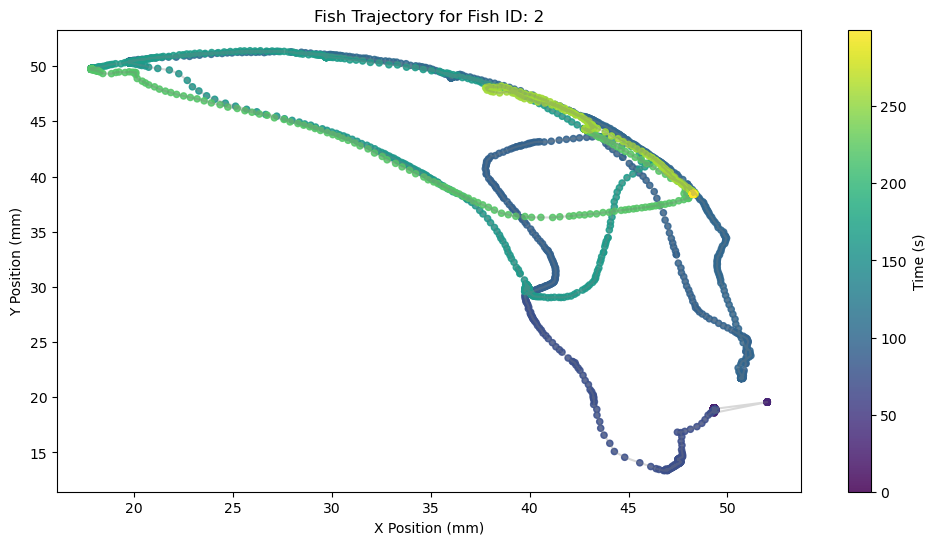

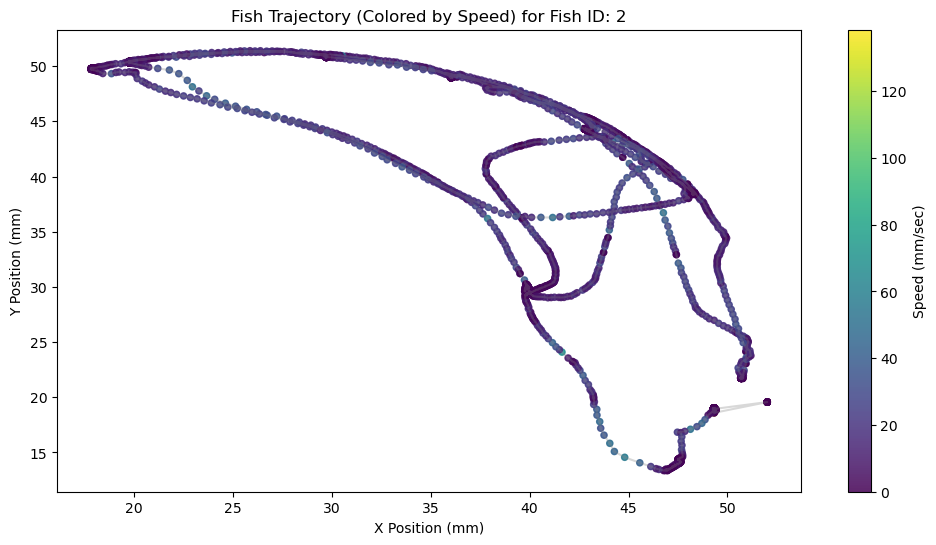

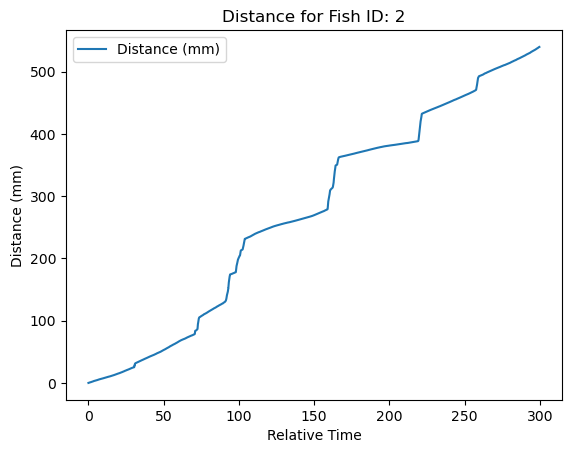

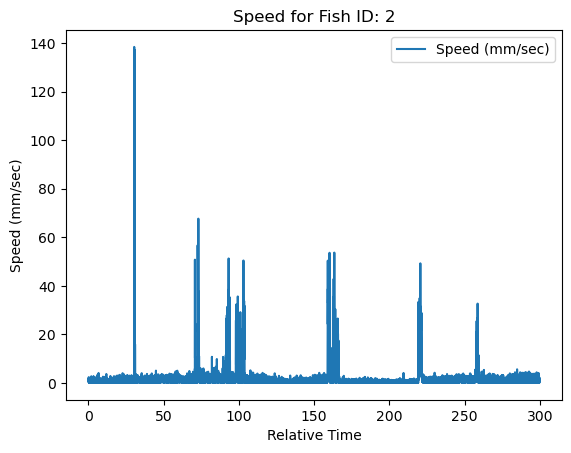

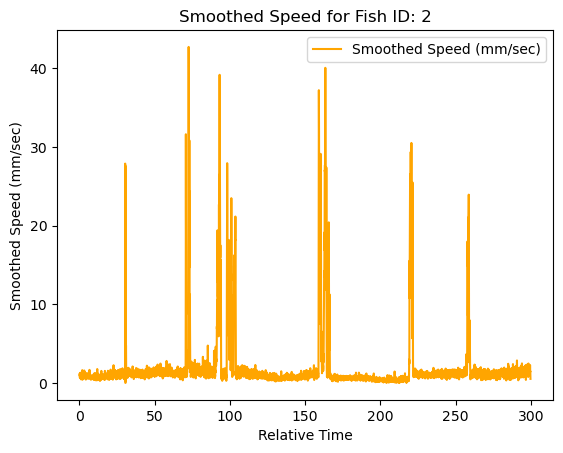

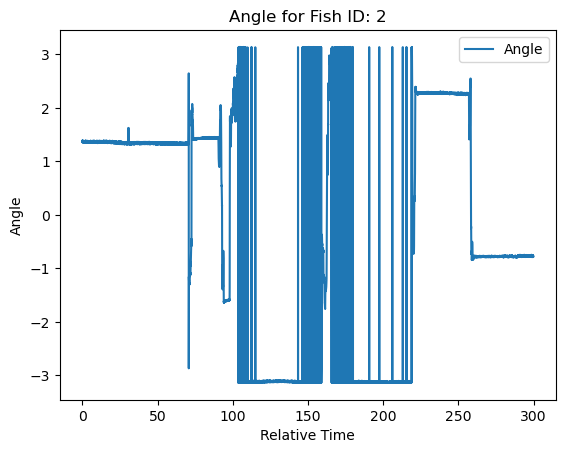

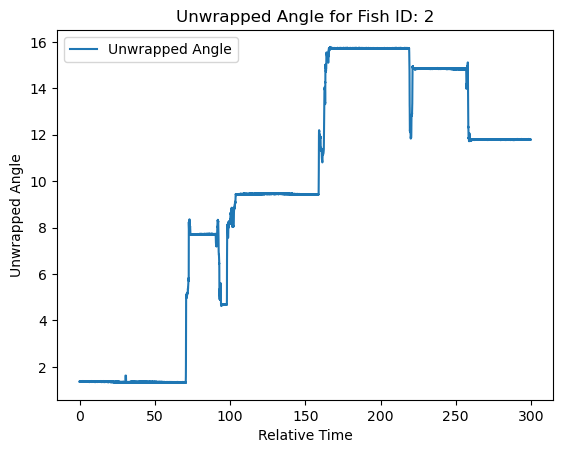

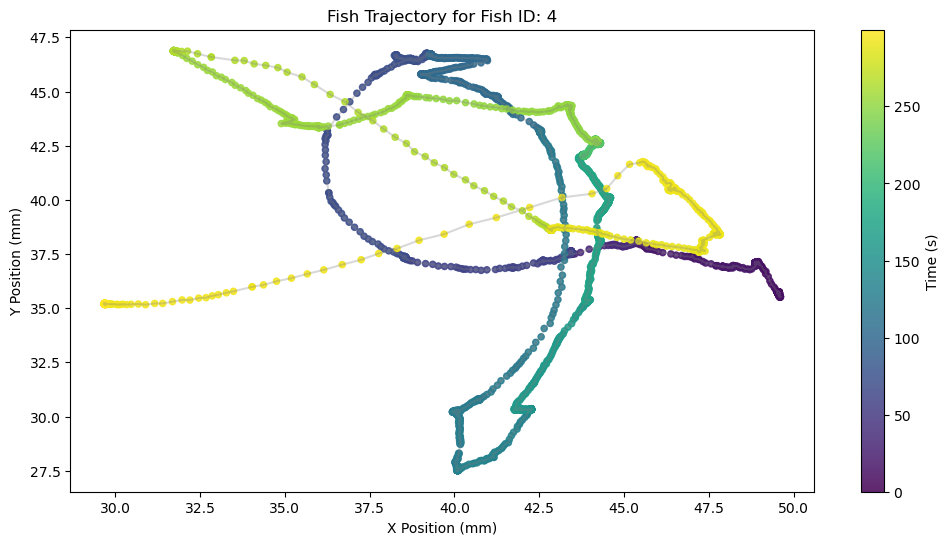

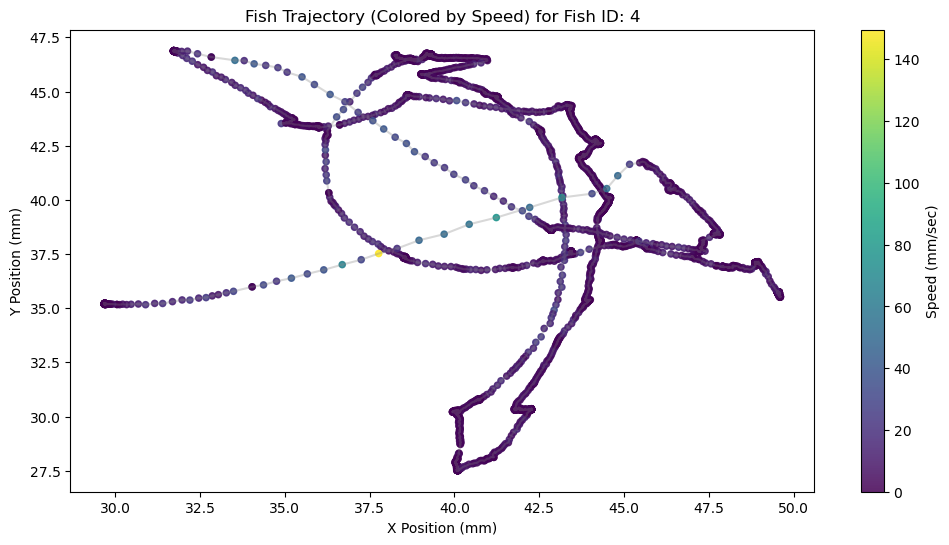

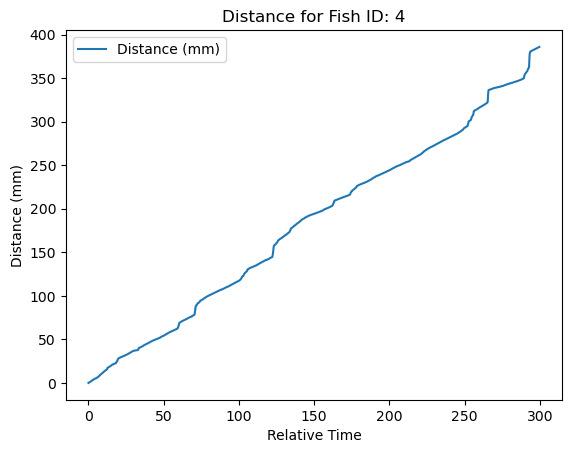

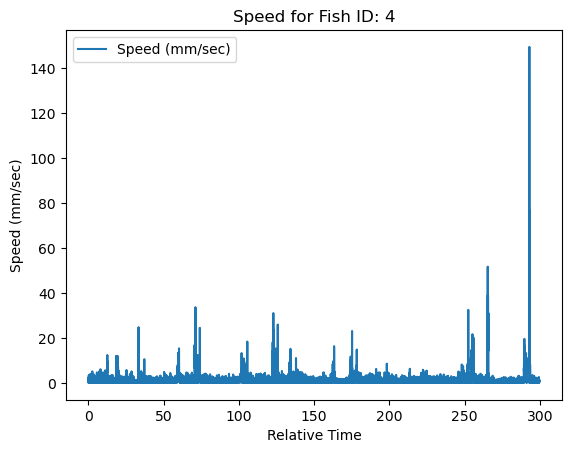

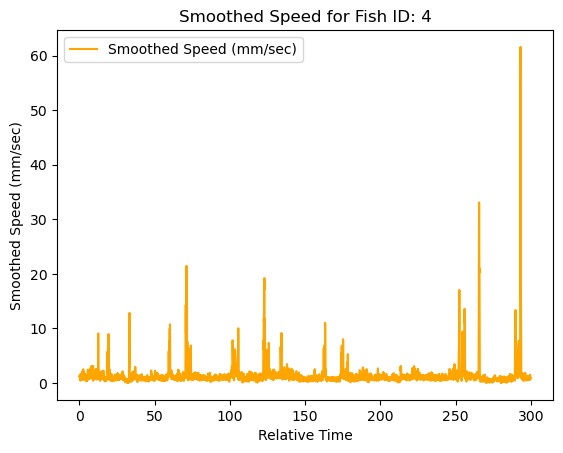

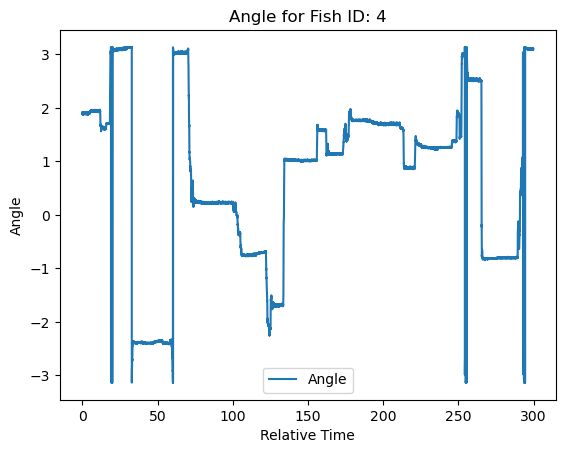

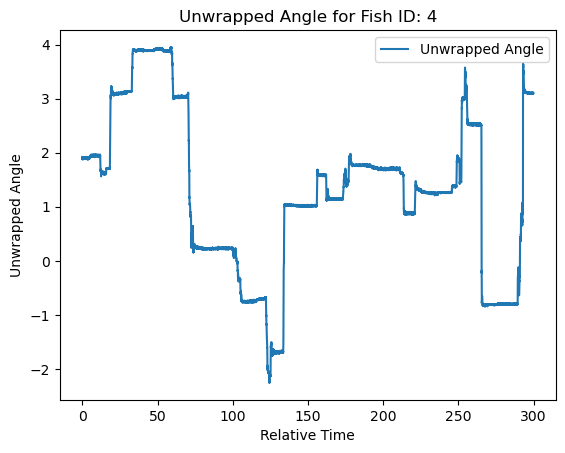

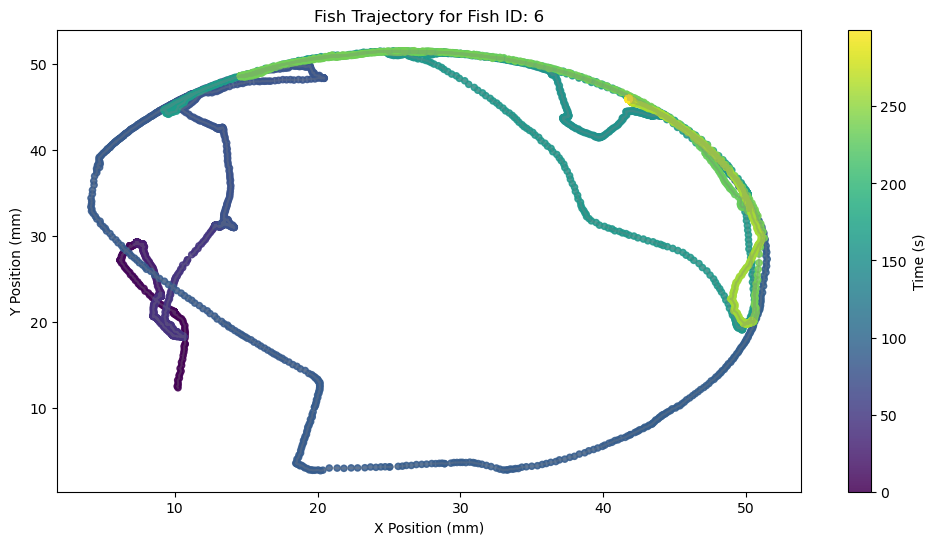

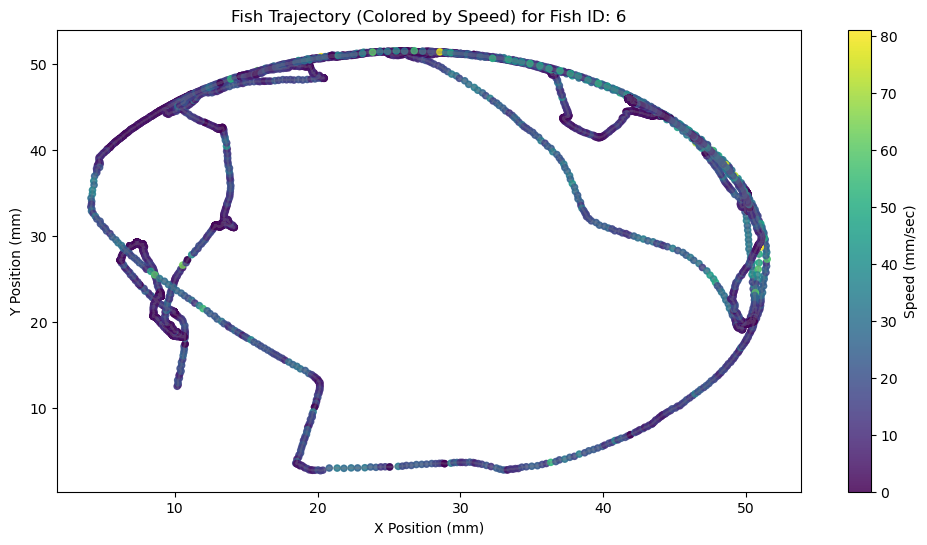

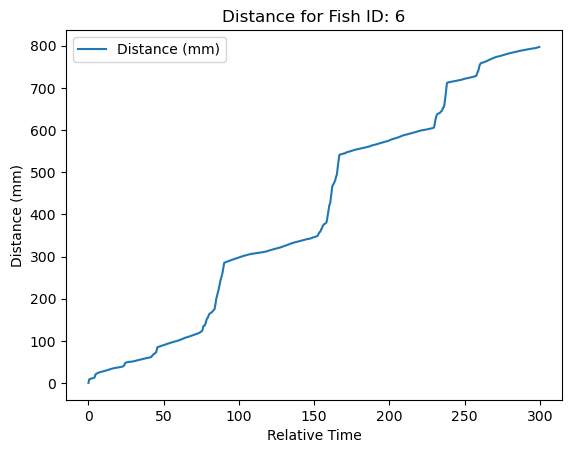

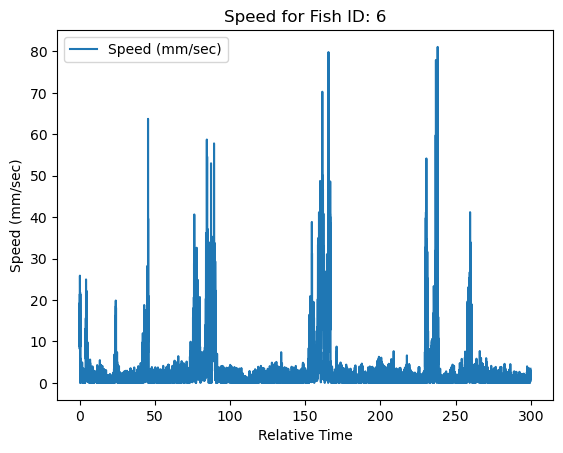

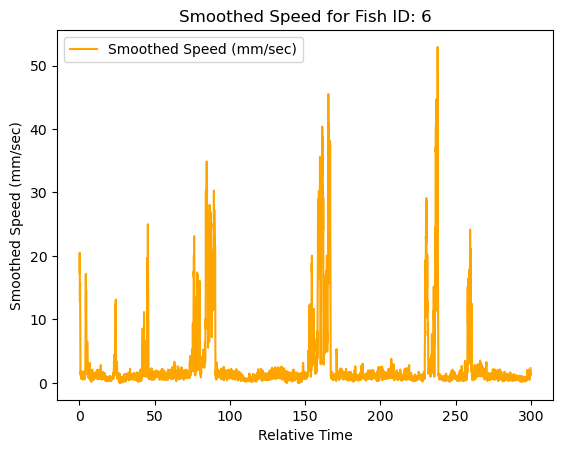

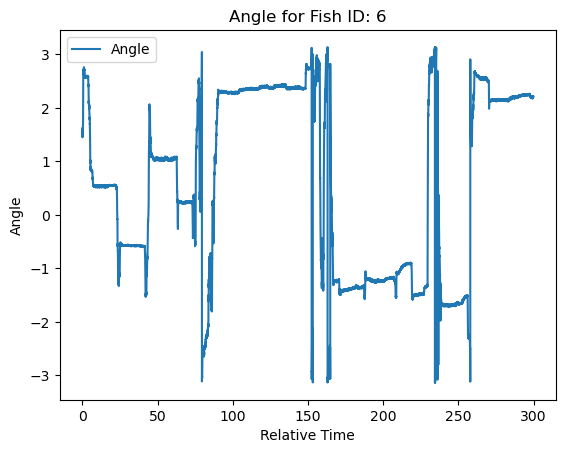

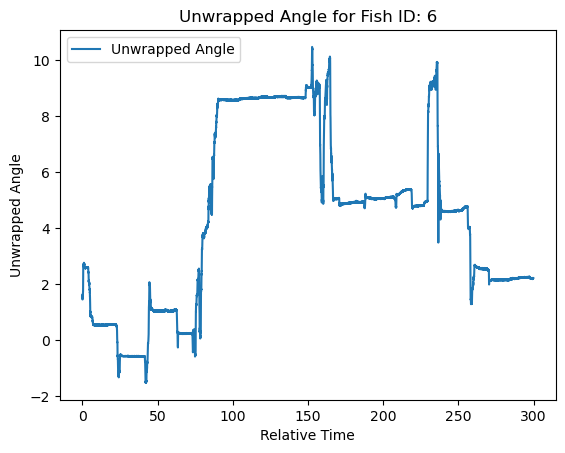

Total Number of bouts detected: 28
Average bout duration: 0.49 time units
Average bout peak speed: 24.16 mm/sec
Average bout mean speed: 16.96 mm/sec
Average inter-bout interval: 9.11 time units
Average angle change: -0.37 radians
Average distance traveled: 231.67 mm

Top 5 bouts by peak speed:
    bout_id  start_time  duration  peak_speed
3         4   72.510984  0.266493   42.726724
19       22  162.442337  1.767702   40.066283
8        10   92.663503  1.380629   39.180957
16       19  158.943137  0.700186   37.223600
2         3   70.691717  0.246898   31.621311


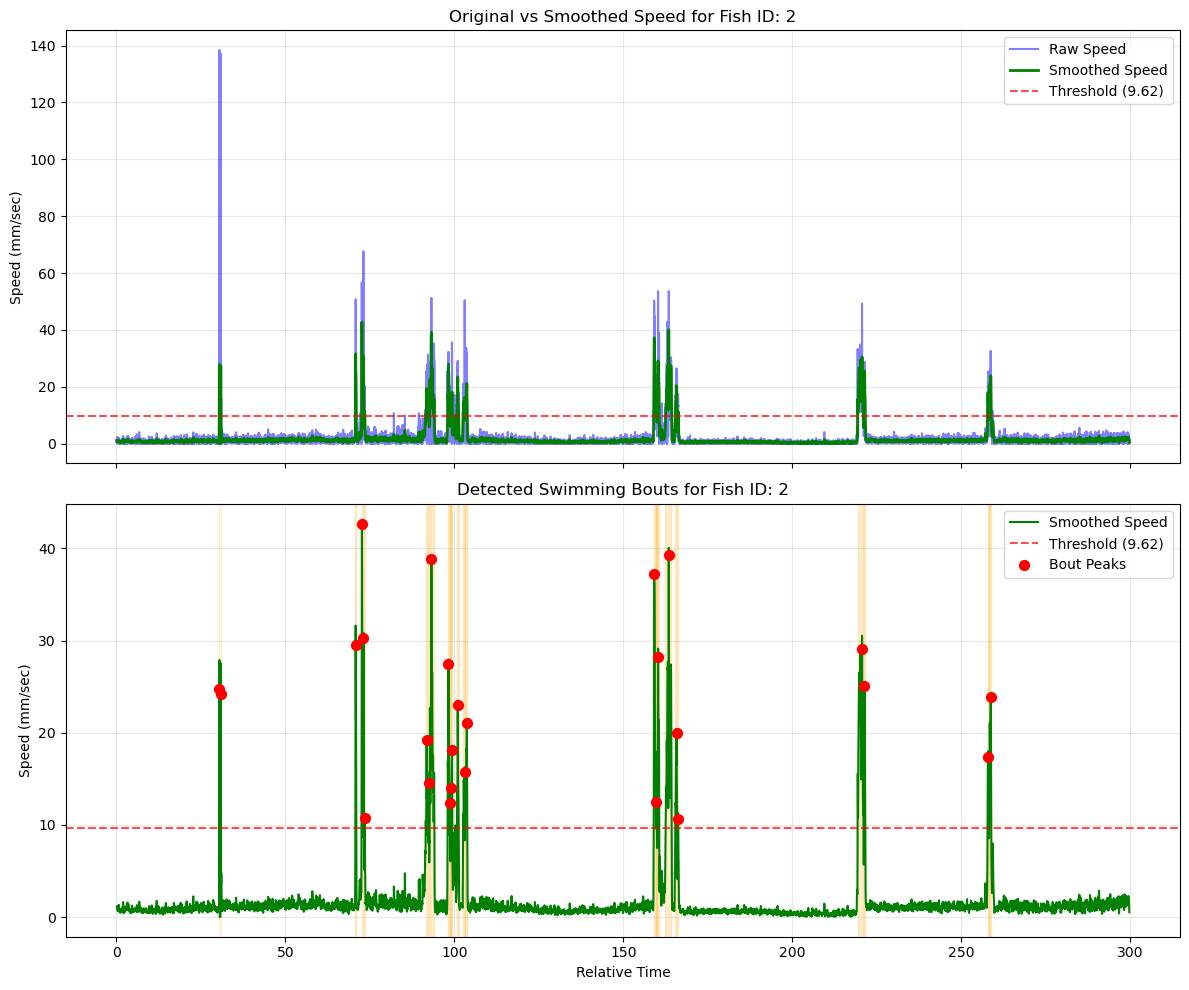

Histograms for Fish ID: 2


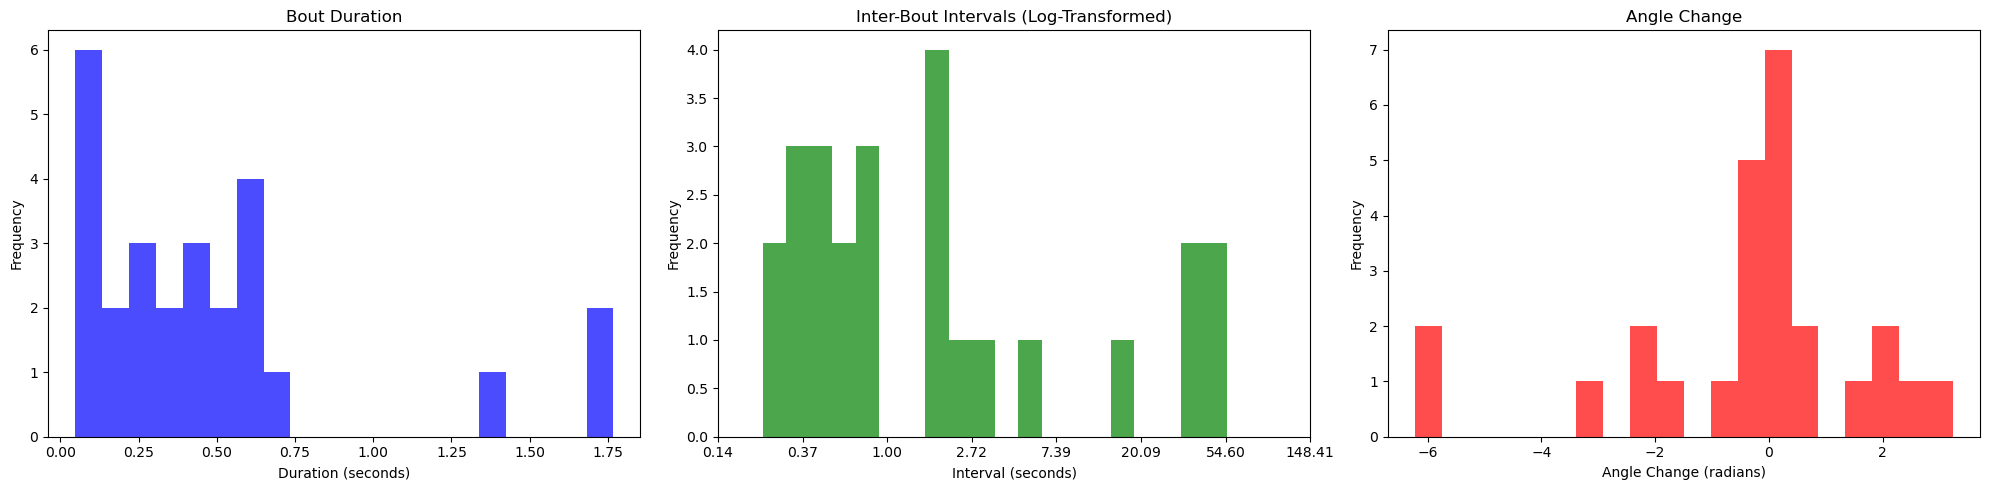

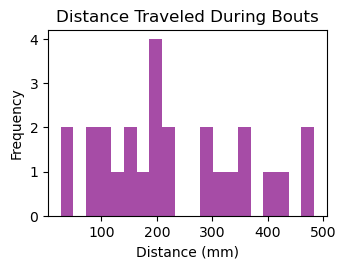

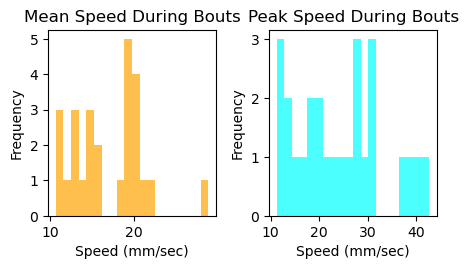

Total Number of bouts detected: 23
Average bout duration: 0.26 time units
Average bout peak speed: 14.00 mm/sec
Average bout mean speed: 10.35 mm/sec
Average inter-bout interval: 12.74 time units
Average angle change: -0.19 radians
Average distance traveled: 192.68 mm

Top 5 bouts by peak speed:
    bout_id  start_time  duration  peak_speed
82       23  292.853506  0.634156   61.597188
78       19  265.290343  0.612963   33.082829
65        6   70.544361  0.718226   21.464174
70       11  122.334843  0.960852   19.221565
75       16  252.244128  0.337679   17.060776


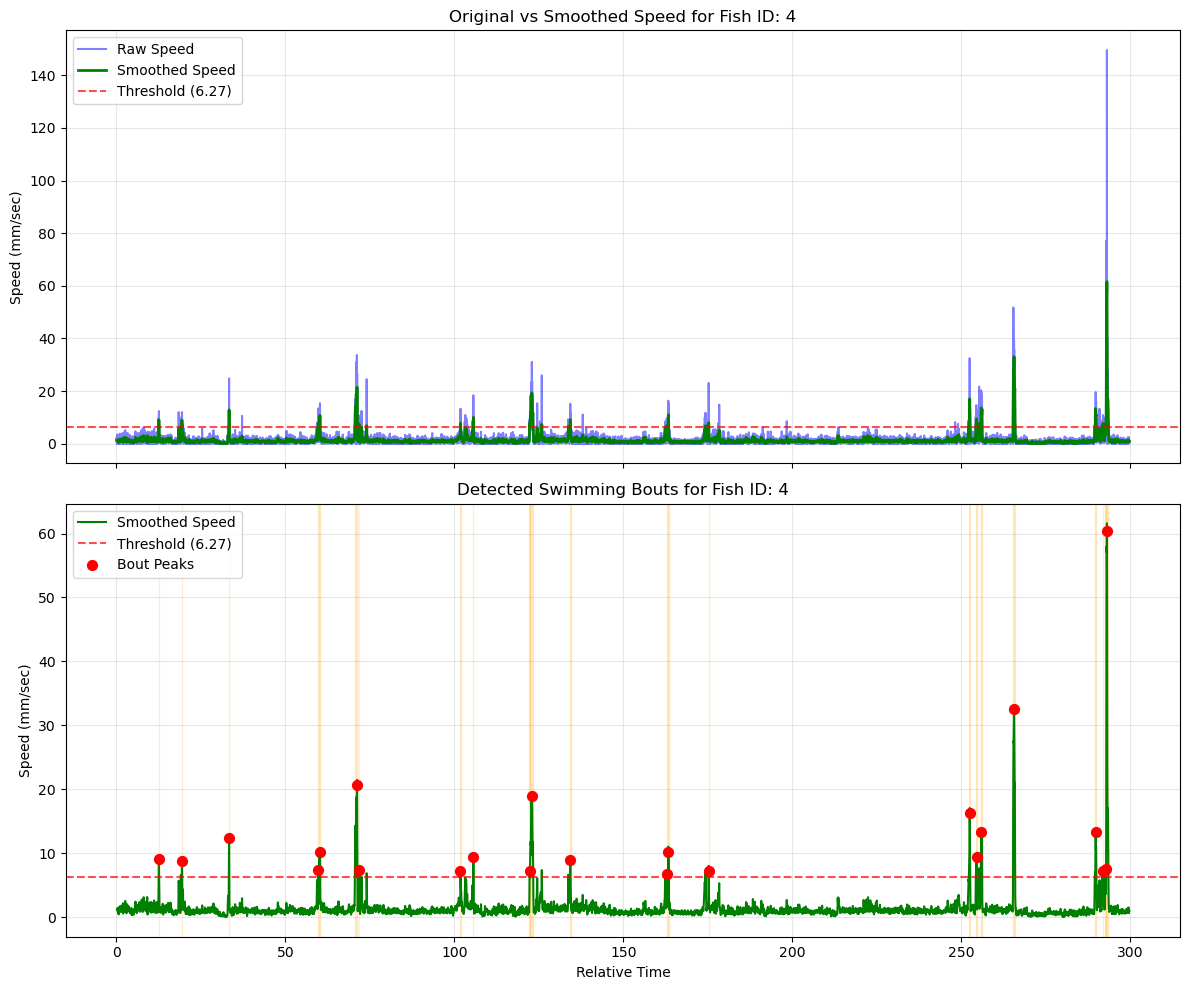

Histograms for Fish ID: 4


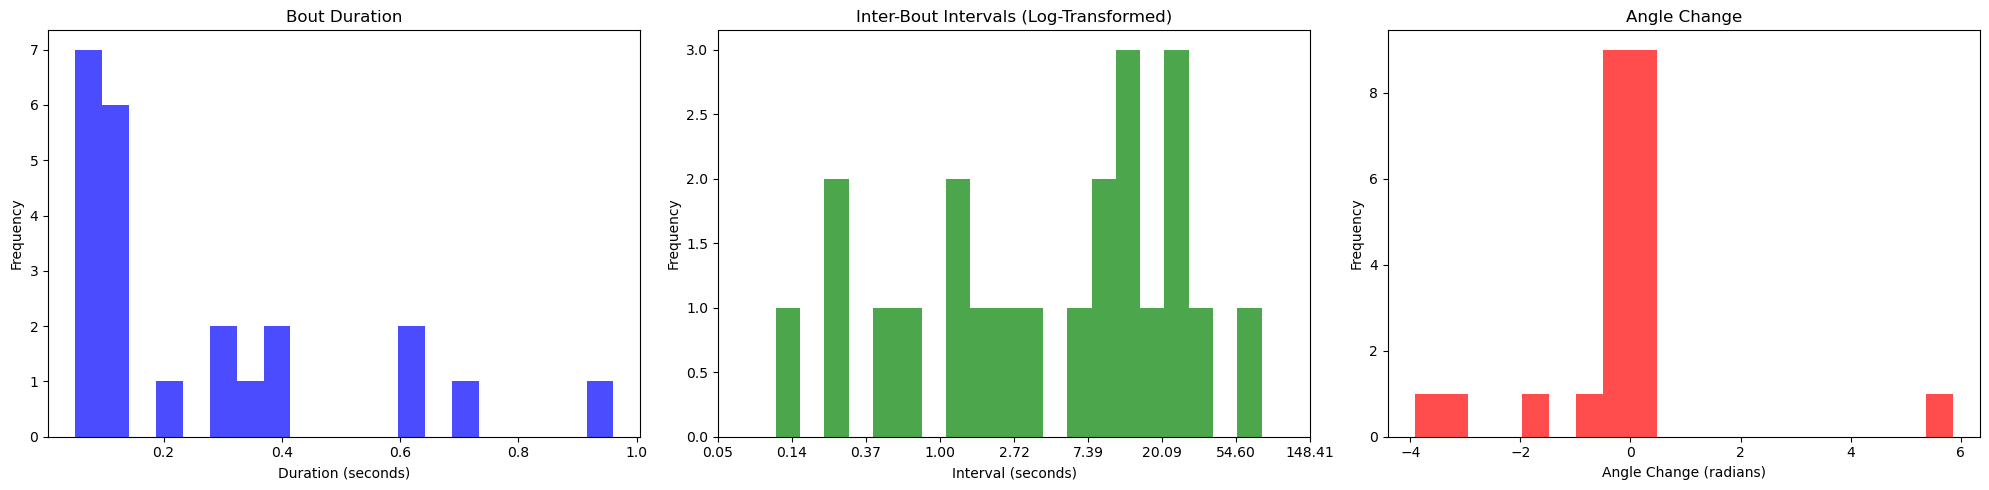

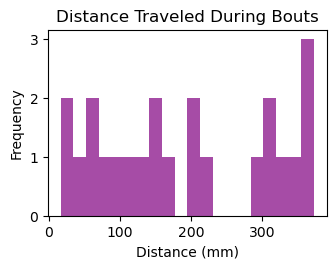

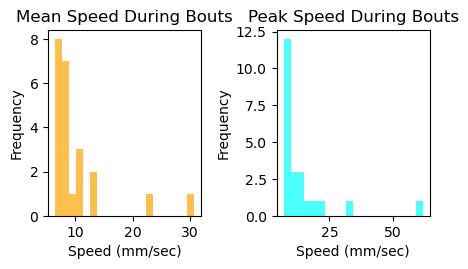

Total Number of bouts detected: 35
Average bout duration: 0.47 time units
Average bout peak speed: 23.53 mm/sec
Average bout mean speed: 18.83 mm/sec
Average inter-bout interval: 7.88 time units
Average angle change: 0.04 radians
Average distance traveled: 364.80 mm

Top 5 bouts by peak speed:
     bout_id  start_time  duration  peak_speed
112       31  236.621840  1.621210   52.928742
106       25  164.952624  1.789390   45.504137
102       21  160.589921  1.506648   40.382499
101       20  158.329328  1.731095   35.631495
93        11   83.963463  1.413915   34.882197


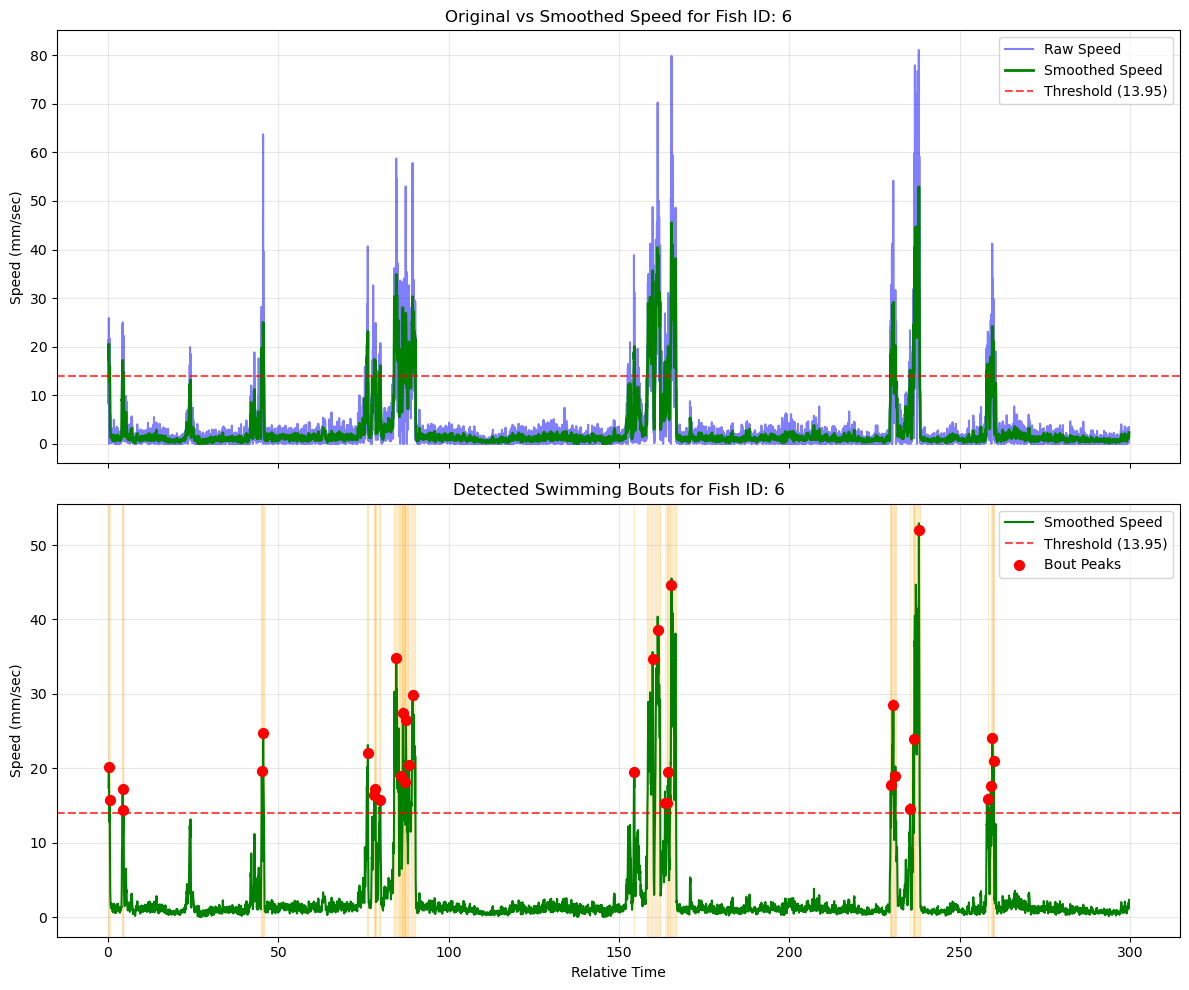

Histograms for Fish ID: 6


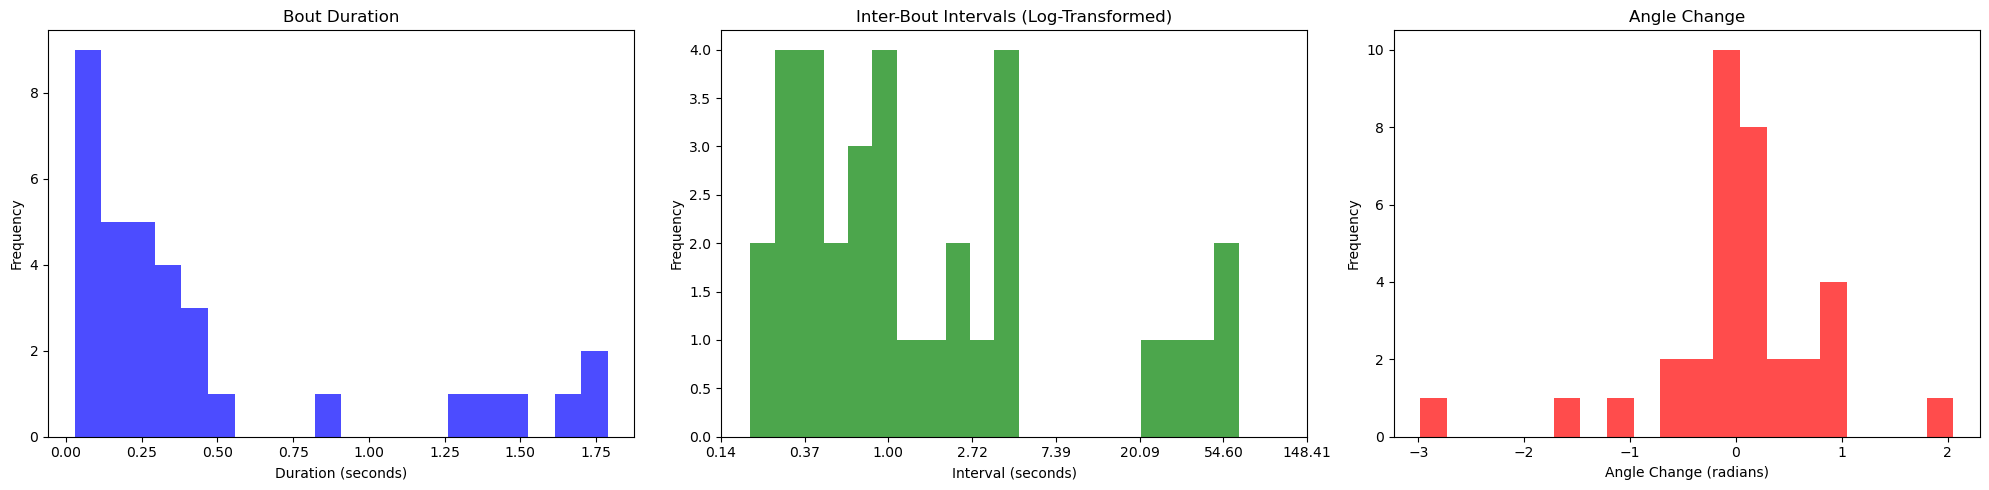

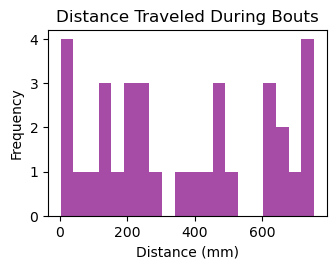

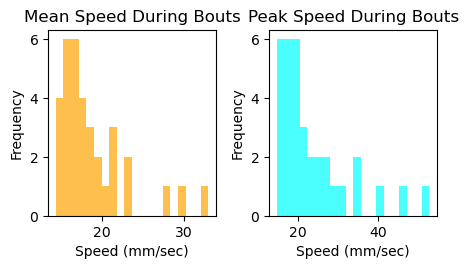

In [23]:
# Plot trajectory, distance, speed, angle, and unwrapped angle for selected fish_ids
selected_fish_ids = [2,4,6]  # Choose 3 fish_ids
for fish_id in selected_fish_ids:
    fish_data = derived_metrics_df[derived_metrics_df['fish_id'] == fish_id]
    
    # Trajectory plot
    plt.figure(figsize=(12, 6))
    plt.scatter(
        fish_data['centroid_x'] / PIX_PER_MM, 
        fish_data['centroid_y'] / PIX_PER_MM, 
        c=fish_data['relative_time'], 
        cmap='viridis', 
        s=20, 
        alpha=0.85
    )
    plt.colorbar(label='Time (s)')
    plt.title(f'Fish Trajectory for Fish ID: {fish_id}')
    plt.xlabel('X Position (mm)')
    plt.ylabel('Y Position (mm)')
    plt.plot(
        fish_data['centroid_x'] / PIX_PER_MM, 
        fish_data['centroid_y'] / PIX_PER_MM, 
        color='gray', 
        linewidth=1.5, 
        alpha=0.3
    )
    plt.show()
    
    # Trajectory plot colored by cumulative speed
    plt.figure(figsize=(12, 6))
    plt.scatter(
        fish_data['centroid_x'] / PIX_PER_MM, 
        fish_data['centroid_y'] / PIX_PER_MM, 
        c=fish_data['speed'], 
        cmap='viridis', 
        s=20, 
        alpha=0.85
    )
    plt.colorbar(label='Speed (mm/sec)')
    plt.title(f'Fish Trajectory (Colored by Speed) for Fish ID: {fish_id}')
    plt.xlabel('X Position (mm)')
    plt.ylabel('Y Position (mm)')
    plt.plot(
        fish_data['centroid_x'] / PIX_PER_MM, 
        fish_data['centroid_y'] / PIX_PER_MM, 
        color='gray', 
        linewidth=1.5, 
        alpha=0.3
    )
    plt.show()
    
    # Distance plot
    plt.figure()
    plt.plot(fish_data['relative_time'], fish_data['distance'], label='Distance (mm)')
    plt.title(f'Distance for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Distance (mm)')
    plt.legend()
    plt.show()
    
    # Speed plot
    plt.figure()
    plt.plot(fish_data['relative_time'], fish_data['speed'], label='Speed (mm/sec)')
    plt.title(f'Speed for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Speed (mm/sec)')
    plt.legend()
    plt.show()
    
    # Smoothed speed plot
    plt.figure()
    plt.plot(fish_data['relative_time'], fish_data['smoothed_speed'], label='Smoothed Speed (mm/sec)', color='orange')
    plt.title(f'Smoothed Speed for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Smoothed Speed (mm/sec)')
    plt.legend()
    plt.show()
    
    # Angle plot
    plt.figure()
    plt.plot(fish_data['relative_time'], fish_data['angle'], label='Angle')
    plt.title(f'Angle for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Angle')
    plt.legend()
    plt.show()
    
    # Unwrapped angle plot
    plt.figure()
    plt.plot(fish_data['relative_time'], fish_data['unwrapped_angle'], label='Unwrapped Angle')
    plt.title(f'Unwrapped Angle for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Unwrapped Angle')
    plt.legend()
    plt.show()

# Print bout statistics and plot bout detection and histograms for selected fish_ids
for fish_id in selected_fish_ids:
    fish_data = derived_metrics_df[derived_metrics_df['fish_id'] == fish_id]
    fish_bout_data = bout_properties_df[bout_properties_df['fish_id'] == fish_id]
    
    # Print bout statistics
    print_bout_statistics(fish_bout_data, fish_id)
    
    # Plot bout detection
    plot_bout_detection(fish_data, fish_bout_data, fish_id)
    plt.show()
    
    # Plot histograms of bout properties for the current fish
    print(f"Histograms for Fish ID: {fish_id}")
    plot_histograms(fish_bout_data)

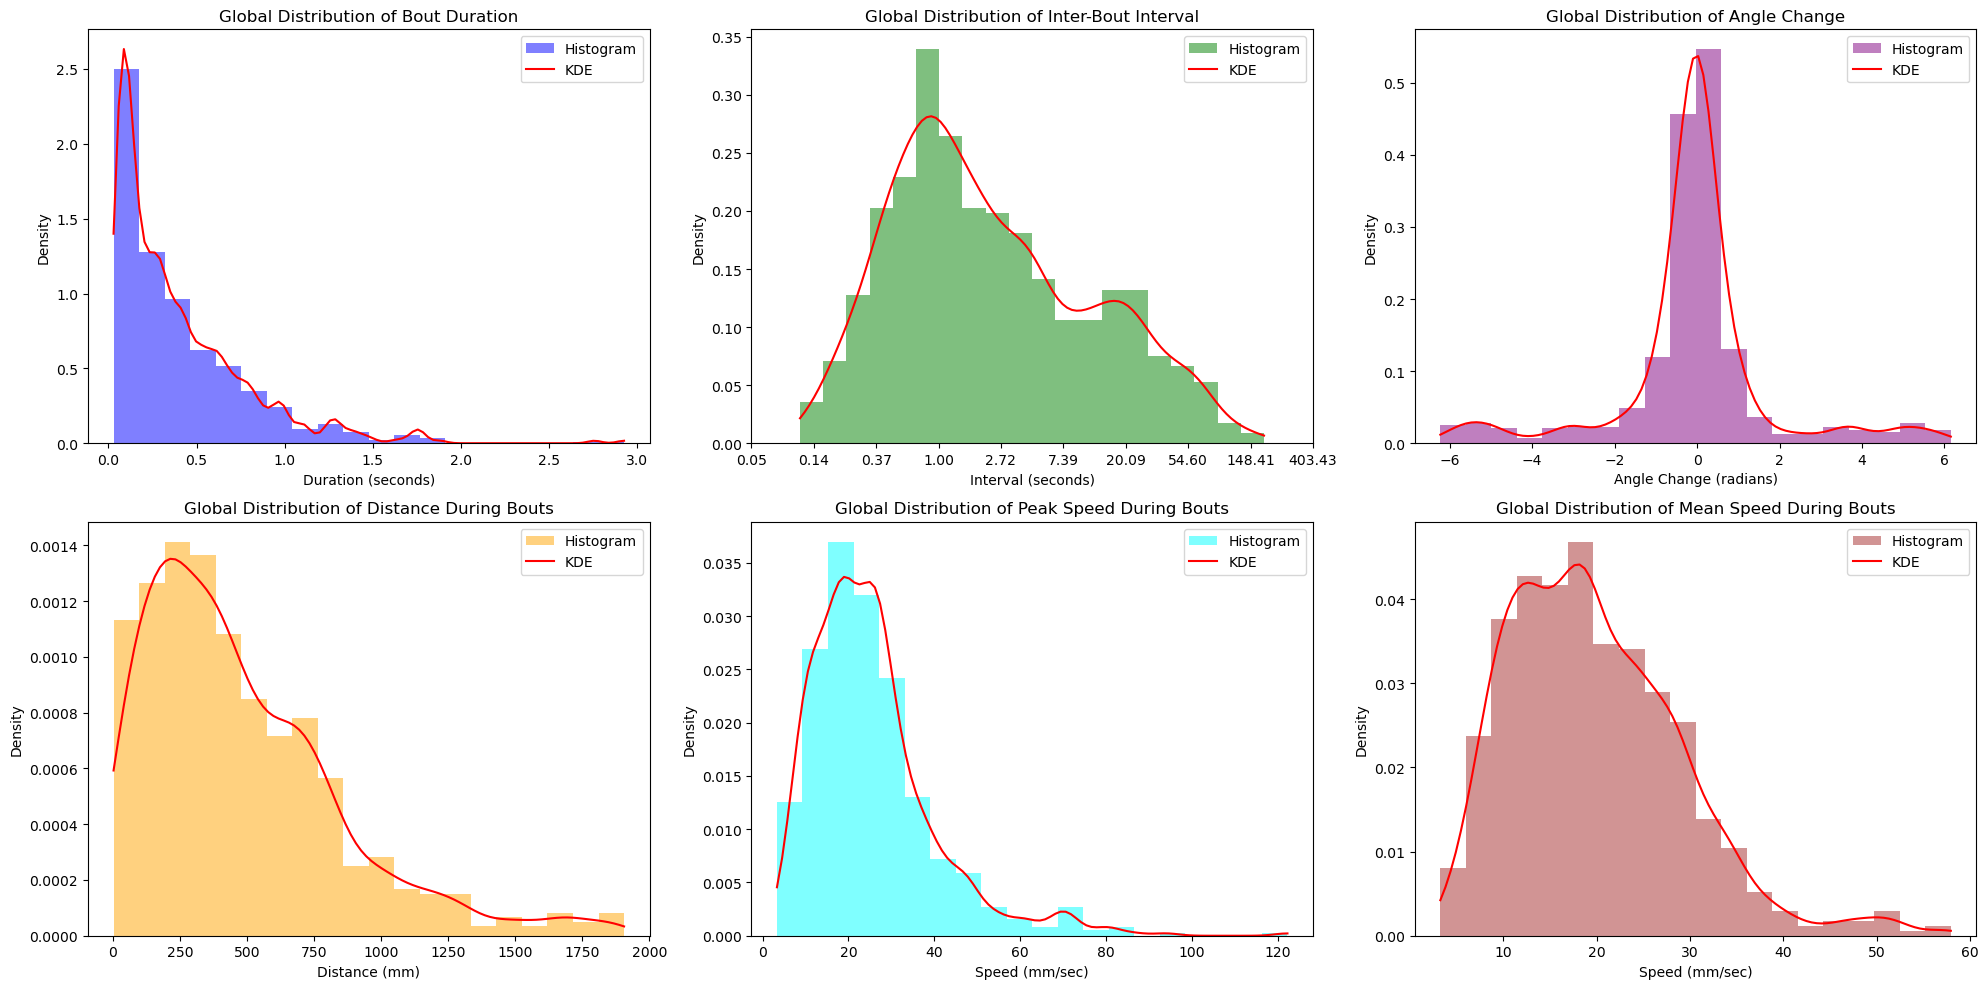

In [8]:
from scipy.stats import gaussian_kde

# Extract bout properties
bout_duration = bout_properties_df['duration'].values
log_intervals = bout_properties_df['log_inter_bout_interval'].dropna().values  # Use precomputed log-transformed values
angle_change = bout_properties_df['angle_change'].values
distance_during_bouts = bout_properties_df['distance_during_bout'].values  # Distance during bouts
peak_speed = bout_properties_df['peak_speed'].values  # Peak speed during bouts
mean_speed = bout_properties_df['mean_speed'].values  # Mean speed during bouts

# --- Plot Global Histograms and Perform KDE ---
plt.figure(figsize=(20, 10))

# Bout duration
plt.subplot(2, 3, 1)
# Histogram
plt.hist(bout_duration, bins=20, density=True, alpha=0.5, color='blue', label='Histogram')
# KDE
kde_duration = gaussian_kde(bout_duration, bw_method=0.1)
x_duration = np.linspace(min(bout_duration), max(bout_duration), 100)
pdf_duration = kde_duration(x_duration)
plt.plot(x_duration, pdf_duration, color='red', label='KDE')
plt.title('Global Distribution of Bout Duration')
plt.xlabel('Duration (seconds)')
plt.ylabel('Density')
plt.legend()

# Inter-bout interval (log-transformed but displayed in original units)
plt.subplot(2, 3, 2)
# Histogram
plt.hist(log_intervals, bins=20, density=True, alpha=0.5, color='green', label='Histogram')
# KDE
kde_intervals = gaussian_kde(log_intervals, bw_method=0.2)
x_intervals = np.linspace(min(log_intervals), max(log_intervals), 100)
pdf_intervals = kde_intervals(x_intervals)
plt.plot(x_intervals, pdf_intervals, color='red', label='KDE')

# Adjust x-axis ticks to show original units
original_ticks = np.exp(plt.xticks()[0])  # Convert log-transformed ticks back to original scale
plt.xticks(np.log(original_ticks), [f"{tick:.2f}" for tick in original_ticks])  # Set ticks and labels

plt.title('Global Distribution of Inter-Bout Interval')
plt.xlabel('Interval (seconds)')
plt.ylabel('Density')
plt.legend()

# Angle change
plt.subplot(2, 3, 3)
# Histogram
plt.hist(angle_change, bins=20, density=True, alpha=0.5, color='purple', label='Histogram')
# KDE
kde_angle = gaussian_kde(angle_change, bw_method=0.2)
x_angle = np.linspace(min(angle_change), max(angle_change), 100)
pdf_angle = kde_angle(x_angle)
plt.plot(x_angle, pdf_angle, color='red', label='KDE')
plt.title('Global Distribution of Angle Change')
plt.xlabel('Angle Change (radians)')
plt.ylabel('Density')
plt.legend()

# Distance during bouts
plt.subplot(2, 3, 4)
# Histogram
plt.hist(distance_during_bouts, bins=20, density=True, alpha=0.5, color='orange', label='Histogram')
# KDE
kde_distance = gaussian_kde(distance_during_bouts, bw_method=0.2)
x_distance = np.linspace(min(distance_during_bouts), max(distance_during_bouts), 100)
pdf_distance = kde_distance(x_distance)
plt.plot(x_distance, pdf_distance, color='red', label='KDE')
plt.title('Global Distribution of Distance During Bouts')
plt.xlabel('Distance (mm)')
plt.ylabel('Density')
plt.legend()

# Peak speed during bouts
plt.subplot(2, 3, 5)
# Histogram
plt.hist(peak_speed, bins=20, density=True, alpha=0.5, color='cyan', label='Histogram')
# KDE
kde_peak_speed = gaussian_kde(peak_speed, bw_method=0.2)
x_peak_speed = np.linspace(min(peak_speed), max(peak_speed), 100)
pdf_peak_speed = kde_peak_speed(x_peak_speed)
plt.plot(x_peak_speed, pdf_peak_speed, color='red', label='KDE')
plt.title('Global Distribution of Peak Speed During Bouts')
plt.xlabel('Speed (mm/sec)')
plt.ylabel('Density')
plt.legend()

# Mean speed during bouts
plt.subplot(2, 3, 6)
# Histogram
plt.hist(mean_speed, bins=20, density=True, alpha=0.5, color='brown', label='Histogram')
# KDE
kde_mean_speed = gaussian_kde(mean_speed, bw_method=0.2)
x_mean_speed = np.linspace(min(mean_speed), max(mean_speed), 100)
pdf_mean_speed = kde_mean_speed(x_mean_speed)
plt.plot(x_mean_speed, pdf_mean_speed, color='red', label='KDE')
plt.title('Global Distribution of Mean Speed During Bouts')
plt.xlabel('Speed (mm/sec)')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

Estimated bouts_per_path: 29


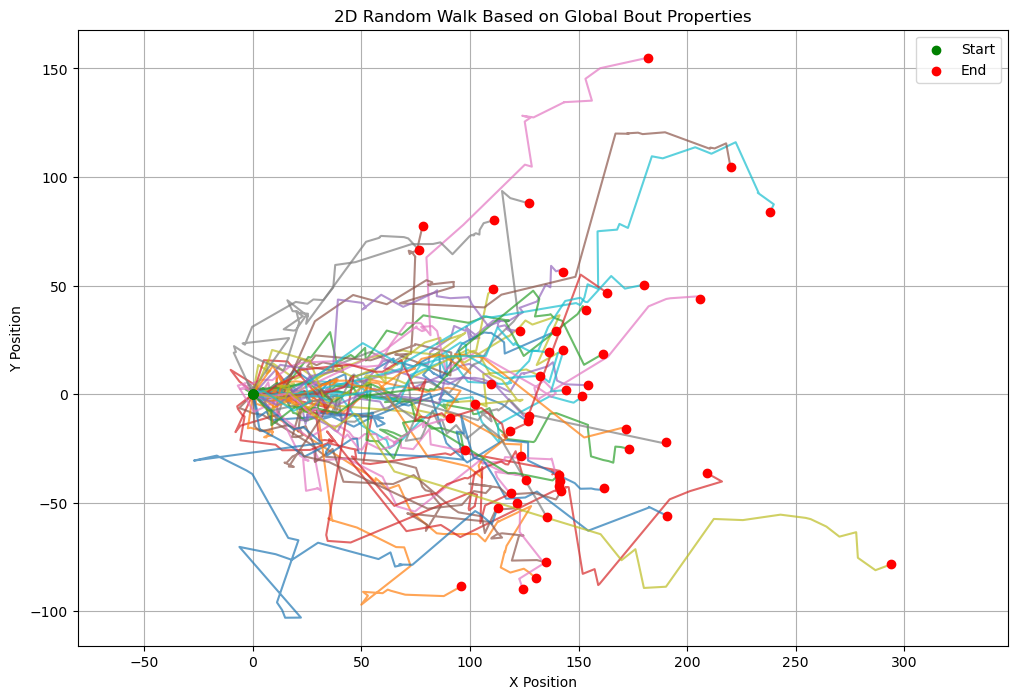

In [9]:
# Simulate 2D random walk based on global bout properties

# Assume KDEs for bout properties are already computed
kde_distance = gaussian_kde(bout_properties_df['distance_during_bout'].values)  # KDE for distance during bouts
kde_log_intervals = gaussian_kde(bout_properties_df['log_inter_bout_interval'].dropna().values)  # KDE for log inter-bout intervals
kde_angle = gaussian_kde(bout_properties_df['angle_change'].values)  # KDE for angle change
kde_duration = gaussian_kde(bout_properties_df['duration'].values)  # KDE for bout duration
kde_mean_speed = gaussian_kde(bout_properties_df['mean_speed'].values)  # KDE for mean speed

# Parameters for the simulation
paths = 50  # Number of independent random walk simulations

# Calculate bouts_per_path dynamically using num_bouts_detected
# Group by fish_id and calculate the mean number of bouts detected per fish
mean_bouts_per_fish = bout_properties_df.groupby('fish_id')['num_bouts_detected'].mean()

# Calculate the overall mean number of bouts across all fish
bouts_per_path = int(mean_bouts_per_fish.mean())
print(f"Estimated bouts_per_path: {bouts_per_path}")


# Resample from KDEs
resampled_distance = kde_distance.resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)  # Step sizes
resampled_log_intervals = kde_log_intervals.resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)  # Log inter-bout intervals
resampled_angle = kde_angle.resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)  # Directions (angles)
resampled_duration = kde_duration.resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)  # Bout durations
resampled_mean_speed = kde_mean_speed.resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)  # Mean speeds

# Initialize positions (start at origin for all paths)
X = np.zeros((paths, bouts_per_path + 1))
Y = np.zeros((paths, bouts_per_path + 1))
time = np.zeros((paths, bouts_per_path + 1))  # Track time for each path


# Simulate 2D random walk with bouts
for path in range(paths):
    for bout in range(bouts_per_path):
        # Bout duration
        bout_duration = resampled_duration[path, bout]
        
        # Speed during the bout
        speed = resampled_mean_speed[path, bout]
        
        # Step size (distance traveled during the bout)
        step_size = speed * bout_duration  # Calculate step size based on speed and duration
        
        # Direction (angle of movement)
        angle = resampled_angle[path, bout]
        
        # Inter-bout interval (time between bouts)
        inter_bout_interval = np.exp(resampled_log_intervals[path, bout])  # Convert log interval back to original scale
        
        # Update position
        X[path, bout + 1] = X[path, bout] + step_size * np.cos(angle)
        Y[path, bout + 1] = Y[path, bout] + step_size * np.sin(angle)
        
        # Update time
        time[path, bout + 1] = time[path, bout] + bout_duration + inter_bout_interval

# Plot the 2D random walk paths
fig, ax = plt.subplots(figsize=(12, 8))
for path in range(paths):
    ax.plot(X[path, :], Y[path, :], alpha=0.7)
ax.scatter(X[:, 0], Y[:, 0], color='green', label='Start', zorder=5)  # Start points
ax.scatter(X[:, -1], Y[:, -1], color='red', label='End', zorder=5)    # End points
ax.set_title("2D Random Walk Based on Global Bout Properties")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.legend()
ax.grid()
plt.axis('equal')
plt.show()

In [24]:
dark_df = pd.read_csv(r'.\processed_data\dark_data_20250409.csv')

# Calculate derived metrics for all fish
derived_metrics_list = []

# Group by fish_id
grouped_df = dark_df.groupby('fish_id')
for fish_id, group in grouped_df:
    # Calculate derived metrics
    group['relative_time'] = get_relative_time(group)
    group['relative_index'] = get_relative_index(group)
    group['distance'] = get_cumulative_distance(group)
    group['angle'], group['unwrapped_angle'] = get_heading_angle(group)
    group['speed'] = get_cumulative_speed(group)
    # Calculate smoothed speed
    group['smoothed_speed'] = smooth_data(group['speed'], method='gaussian', sigma=2)
    # Append the processed group to the list
    derived_metrics_list.append(group)

# Combine all derived metrics into a single DataFrame
derived_metrics_df = pd.concat(derived_metrics_list, ignore_index=True)

# Save the derived metrics DataFrame to a CSV file
date_str = datetime.now().strftime('%Y%m%d')
derived_metrics_path = rf'.\processed_data\derived_metrics_dark_{date_str}.csv'
derived_metrics_df.to_csv(derived_metrics_path, index=False)
print(f"Derived metrics saved to {derived_metrics_path}")

# Load the derived metrics DataFrame
derived_metrics_df = pd.read_csv(derived_metrics_path)

# Initialize an empty list to store bout properties for all fish
bout_properties_list = []

# Group by fish_id
grouped_df = derived_metrics_df.groupby('fish_id')
for fish_id, group in grouped_df:
    # Discard the first point in the trajectory
    group = group.dropna(subset=['speed', 'distance'])
    
    # Detect bouts
    bout_df = detect_fish_bouts_2(group, fish_id=fish_id, method='gaussian', sigma=2)
    
    # Add fish_id to bout_df
    bout_df['fish_id'] = fish_id
    
    # Append bout_df to the list
    bout_properties_list.append(bout_df)

# Combine all bout properties into a single DataFrame
bout_properties_df = pd.concat(bout_properties_list, ignore_index=True)
# Add a small constant (e.g., 1e-6) to avoid issues with log(0)
bout_properties_df['log_inter_bout_interval'] = np.log(bout_properties_df['inter_bout_interval'] + 1e-6)
# Save the bout properties DataFrame to a CSV file
bout_properties_path = rf'.\processed_data\bout_properties_dark_{date_str}.csv'
bout_properties_df.to_csv(bout_properties_path, index=False)
print(f"Bout properties saved to {bout_properties_path}")

bout_properties_df = pd.read_csv(bout_properties_path)

Derived metrics saved to .\processed_data\derived_metrics_dark_20250416.csv
Bout properties saved to .\processed_data\bout_properties_dark_20250416.csv


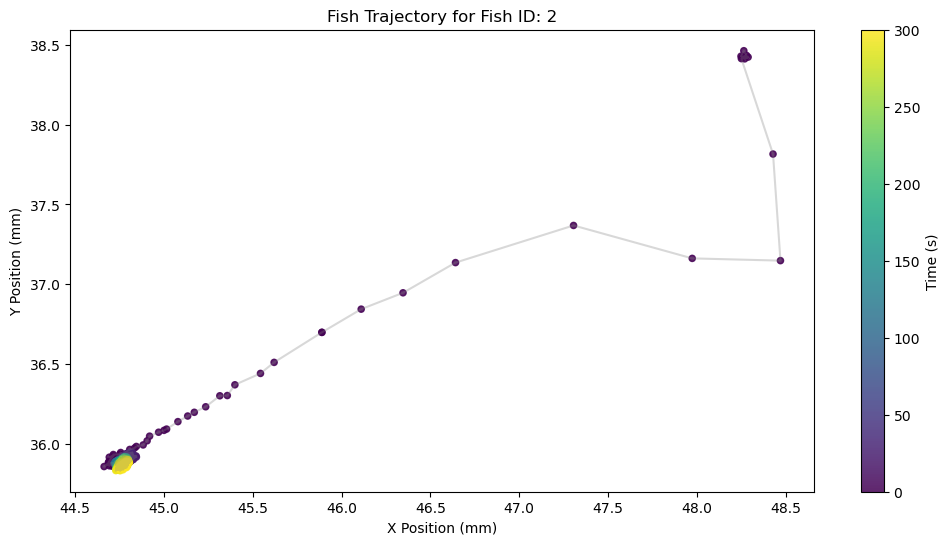

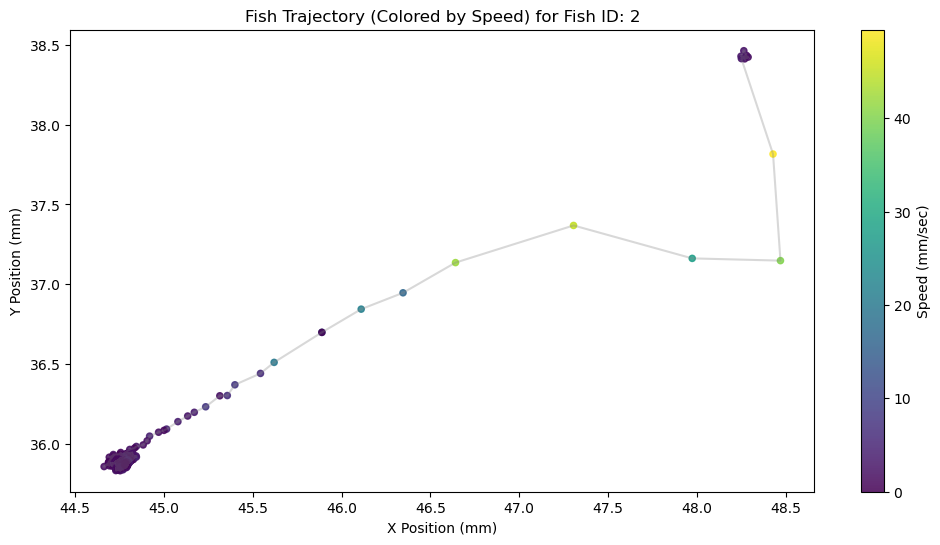

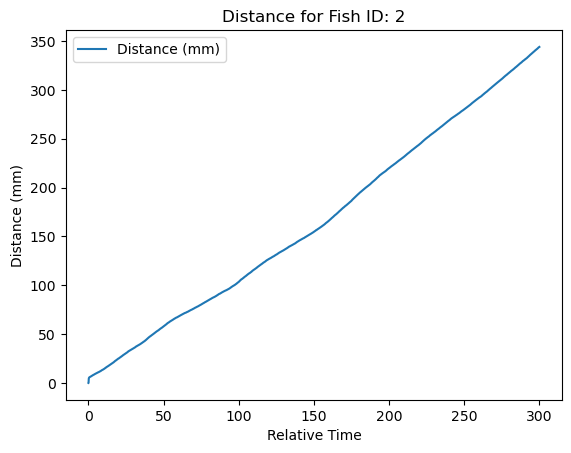

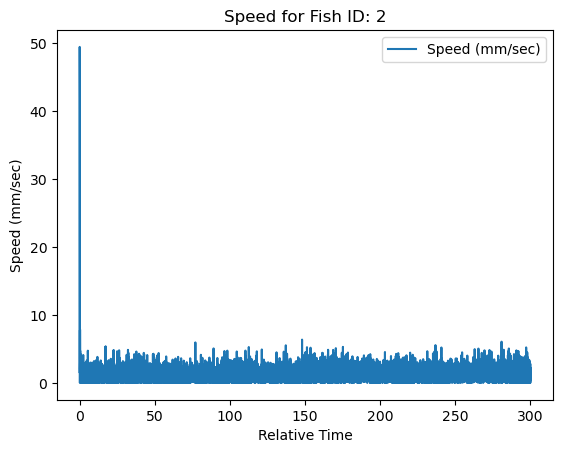

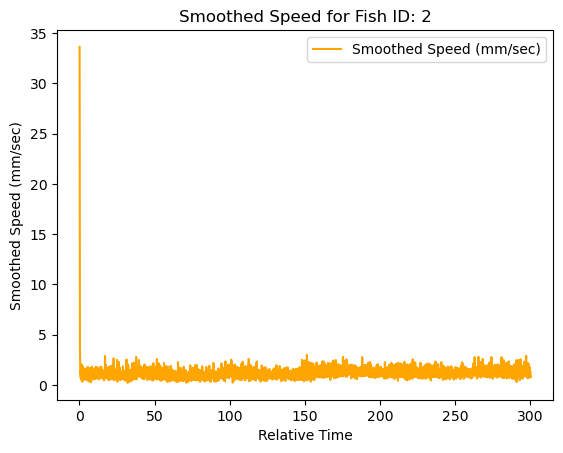

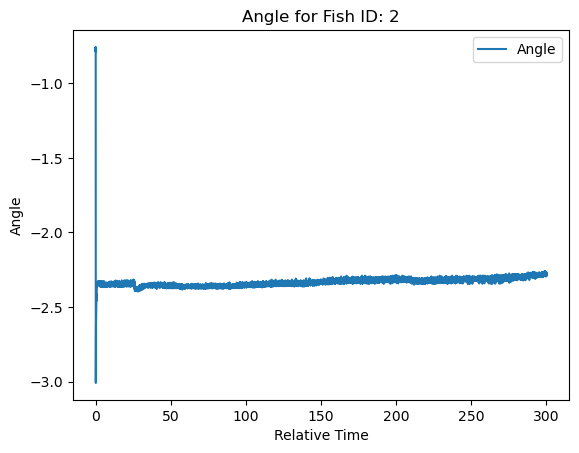

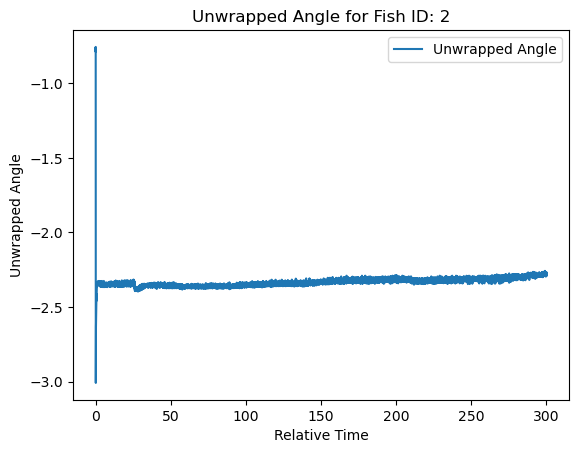

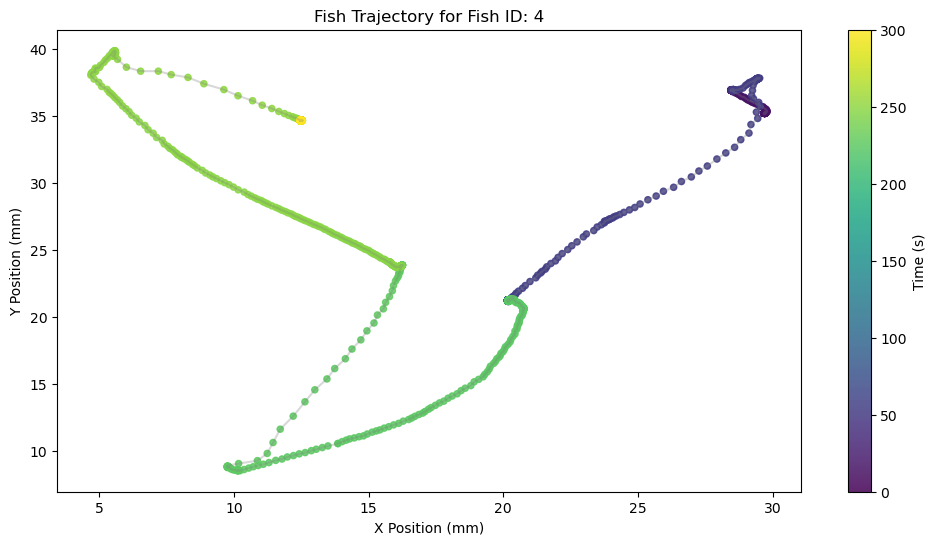

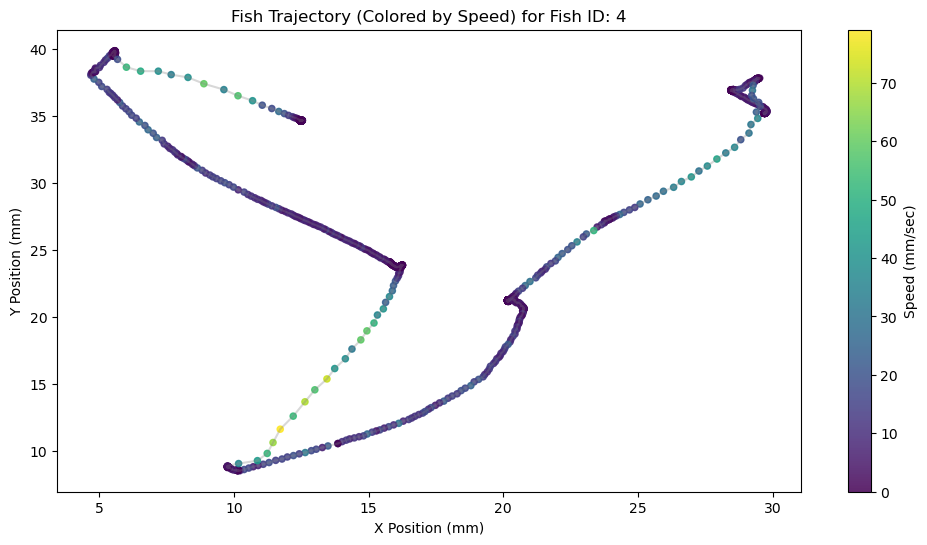

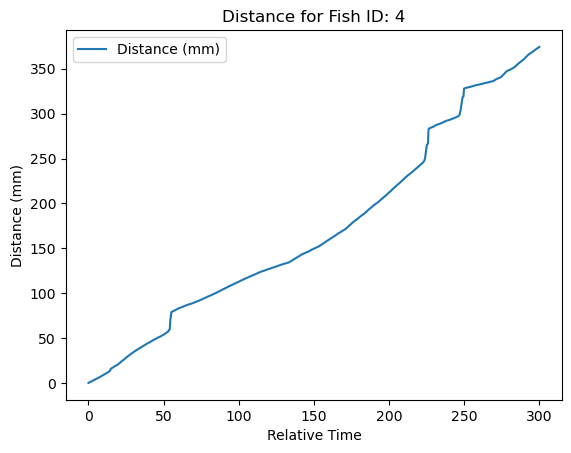

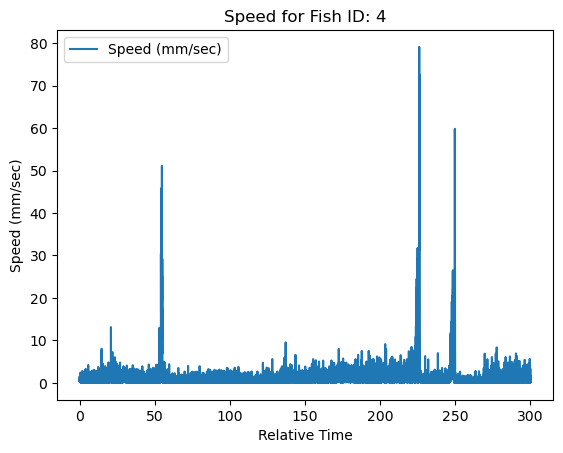

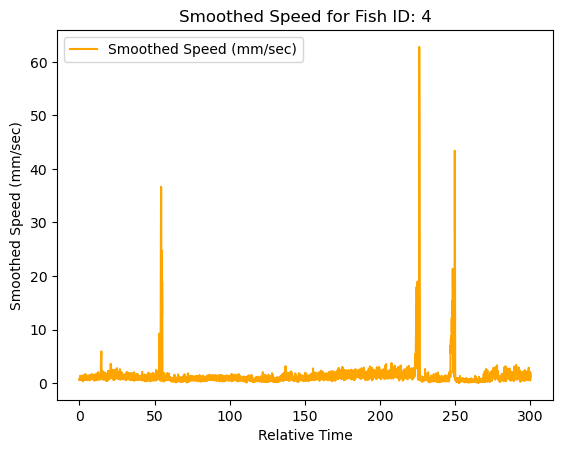

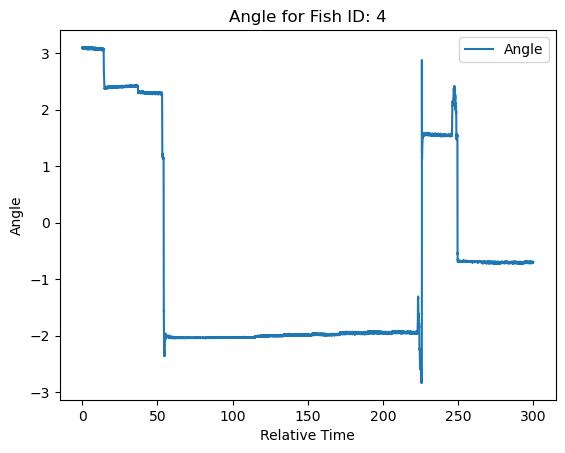

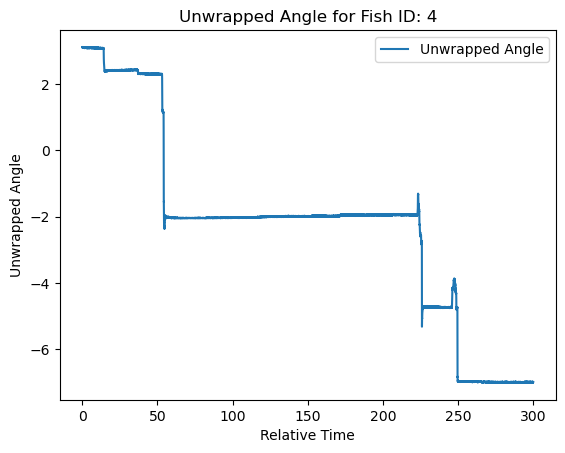

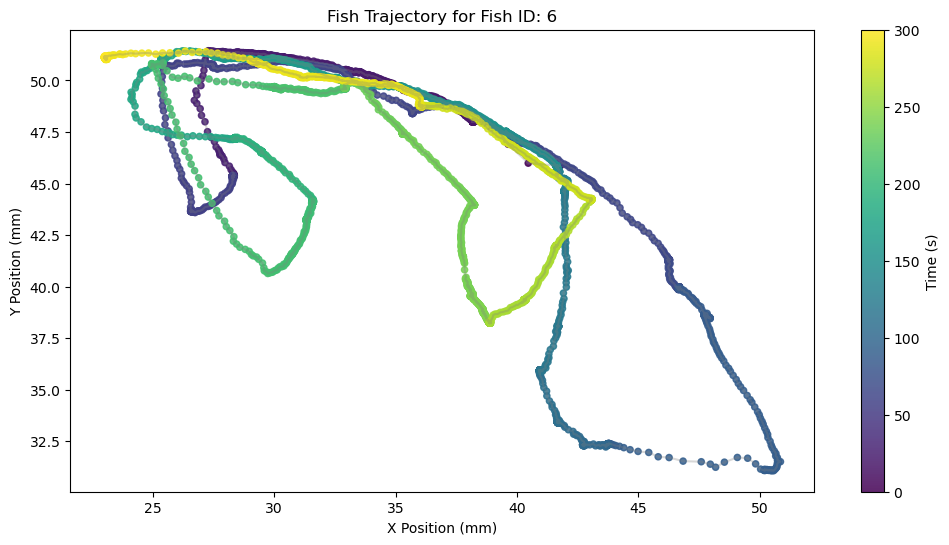

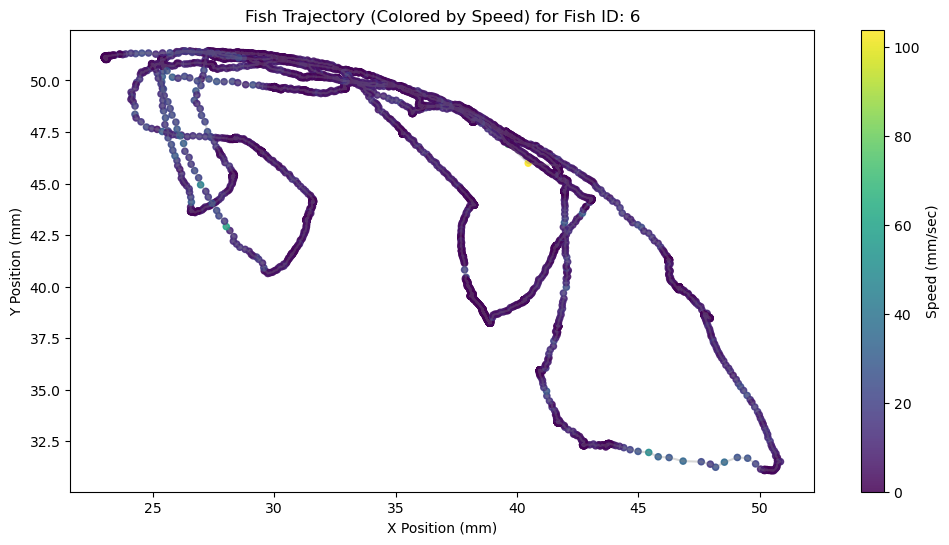

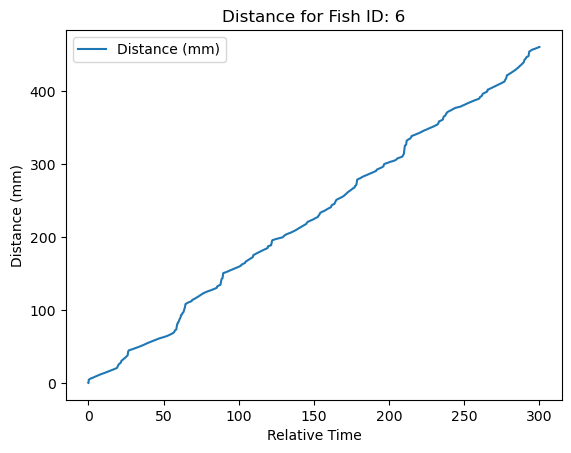

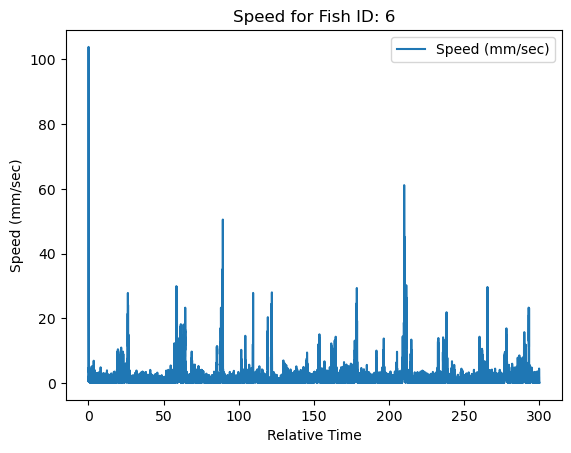

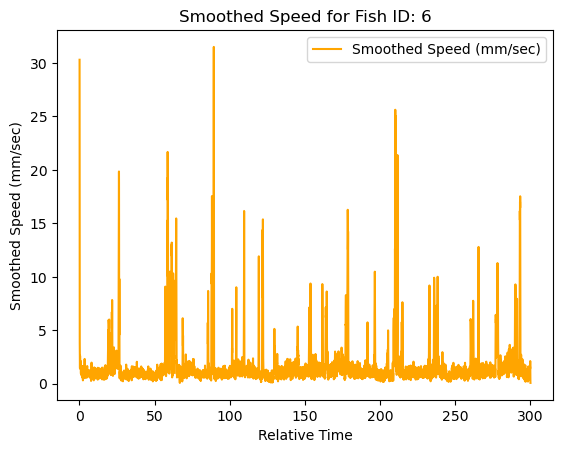

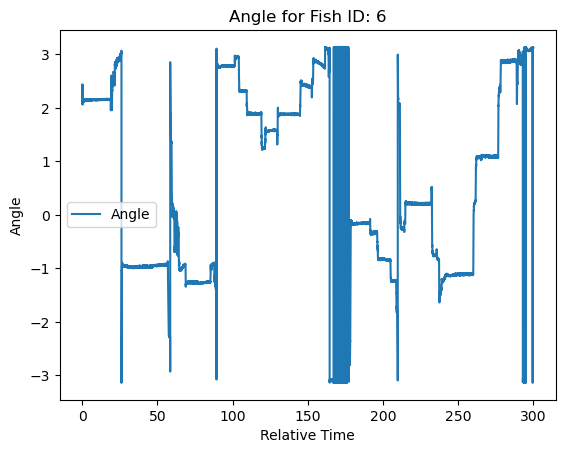

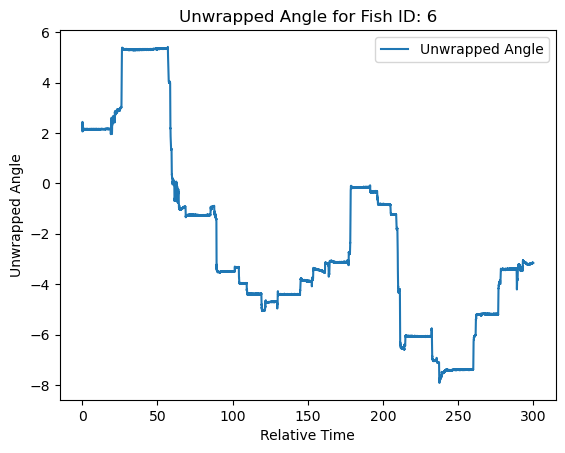

Total Number of bouts detected: 3
Average bout duration: 0.16 time units
Average bout peak speed: 13.13 mm/sec
Average bout mean speed: 6.21 mm/sec
Average inter-bout interval: 94.05 time units
Average angle change: -0.57 radians
Average distance traveled: 121.29 mm

Top 5 bouts by peak speed:
   bout_id  start_time  duration  peak_speed
0        1    0.028577  0.404272   33.632253
1        2  151.326491  0.040561    2.992984
2        3  188.129628  0.036880    2.774885


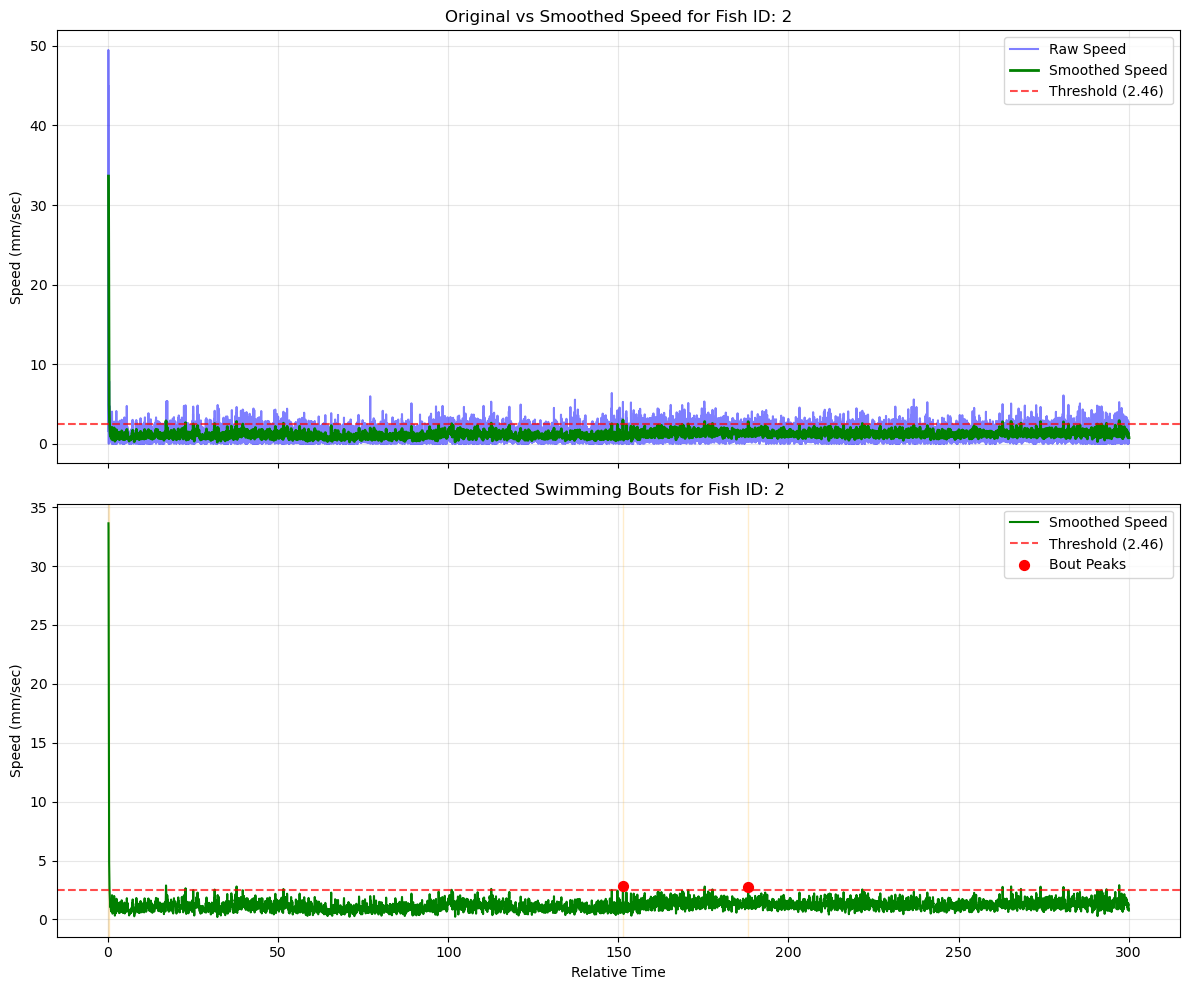

Histograms for Fish ID: 2


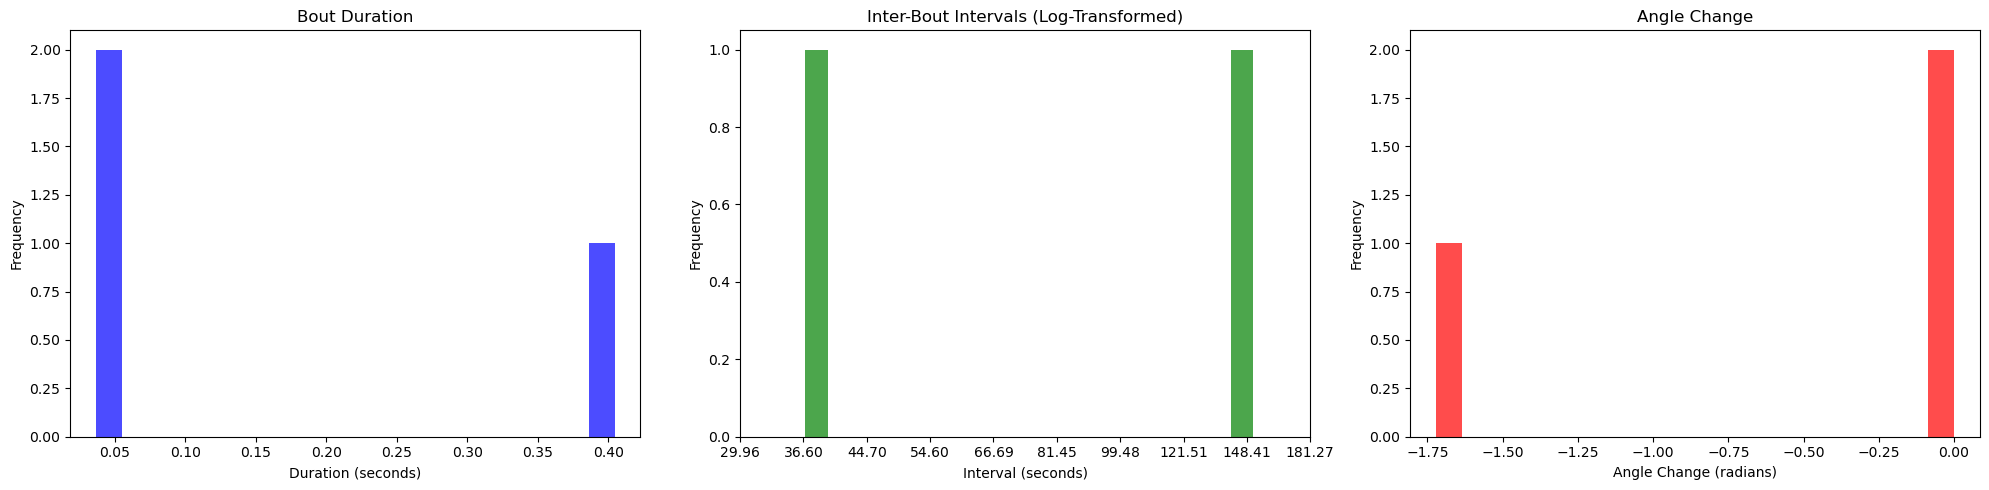

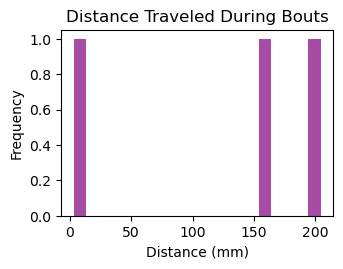

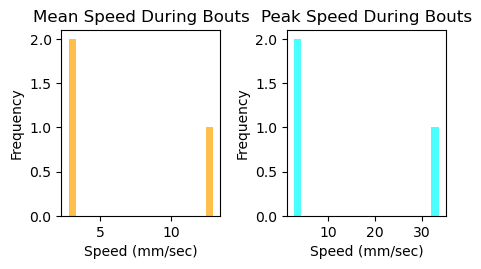

Total Number of bouts detected: 9
Average bout duration: 0.54 time units
Average bout peak speed: 26.10 mm/sec
Average bout mean speed: 16.92 mm/sec
Average inter-bout interval: 24.56 time units
Average angle change: -0.41 radians
Average distance traveled: 219.92 mm

Top 5 bouts by peak speed:
    bout_id  start_time  duration  peak_speed
49        5  225.971802  0.458920   62.798242
53        9  249.610228  0.310047   43.389157
46        2   54.104203  0.512618   36.671015
47        3   54.734126  0.433298   24.723072
51        7  247.104762  1.597690   21.341471


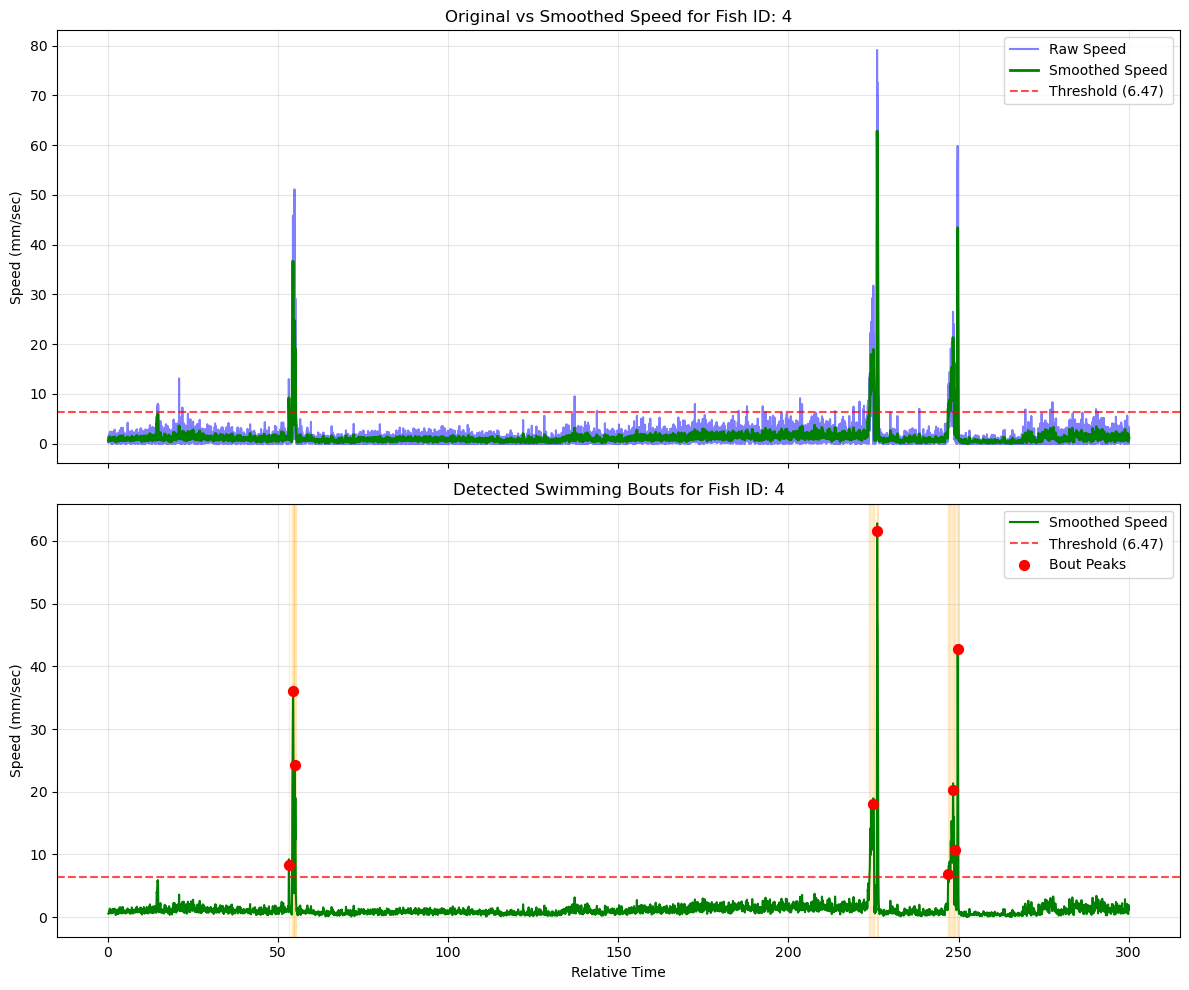

Histograms for Fish ID: 4


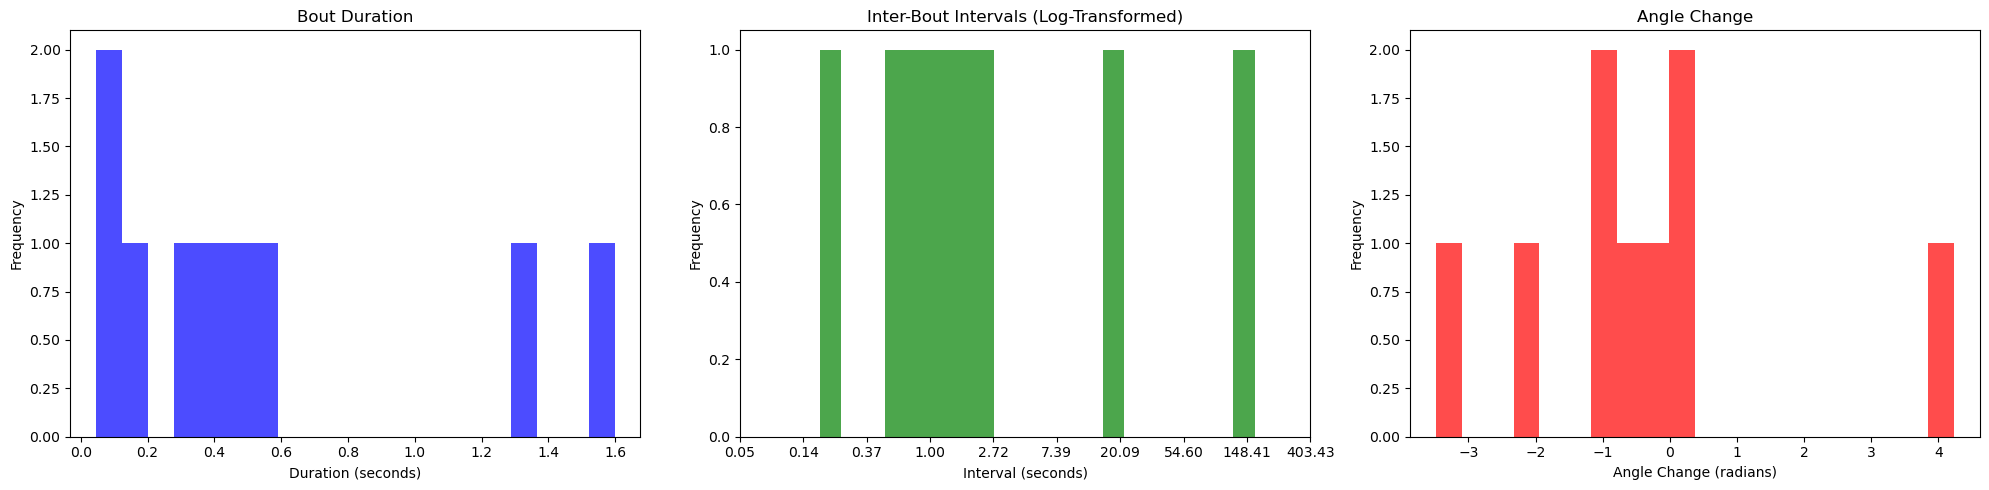

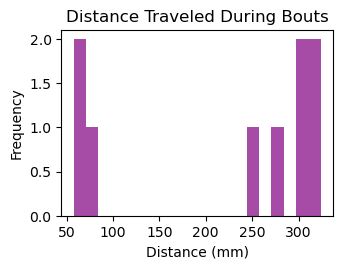

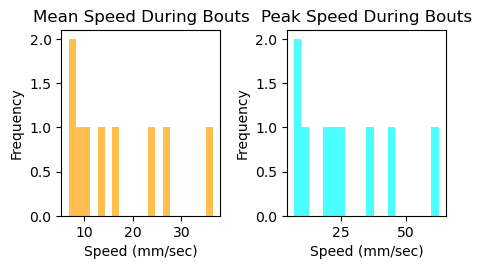

Total Number of bouts detected: 43
Average bout duration: 0.24 time units
Average bout peak speed: 12.72 mm/sec
Average bout mean speed: 9.96 mm/sec
Average inter-bout interval: 6.97 time units
Average angle change: -0.11 radians
Average distance traveled: 225.19 mm

Top 5 bouts by peak speed:
    bout_id  start_time  duration  peak_speed
54        1    0.048251  0.170862   43.687839
69       16   89.246876  0.300039   31.492757
84       31  209.883687  0.701094   25.617962
59        6   58.469205  0.509610   21.673848
85       32  211.452237  0.329356   21.384453


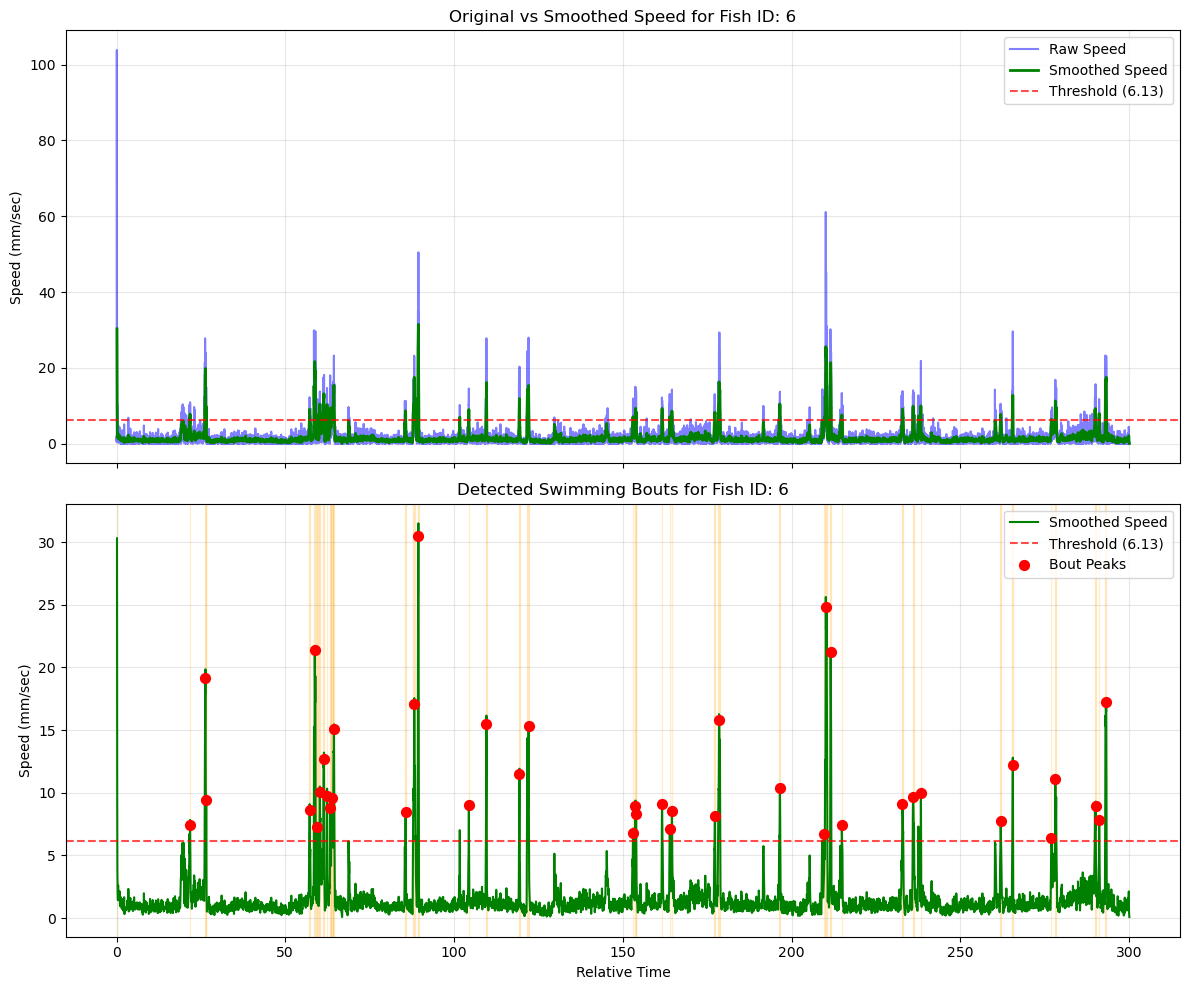

Histograms for Fish ID: 6


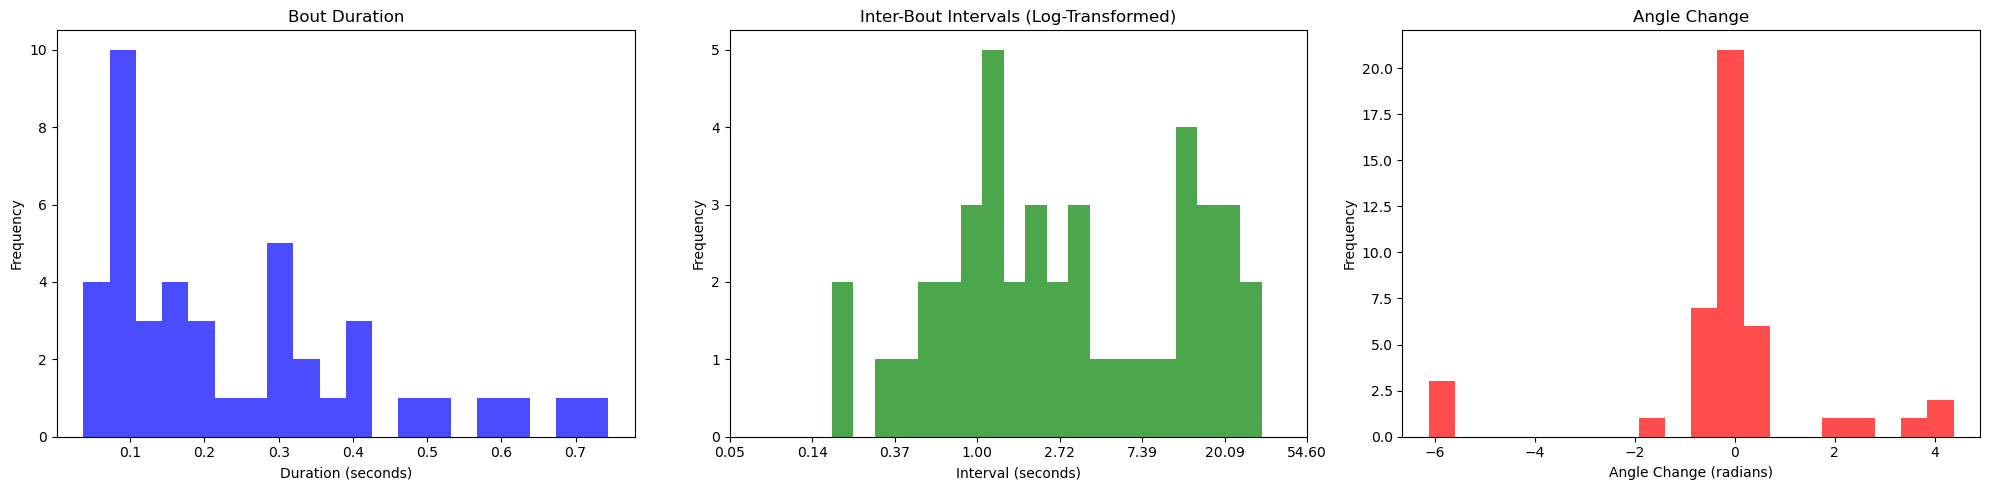

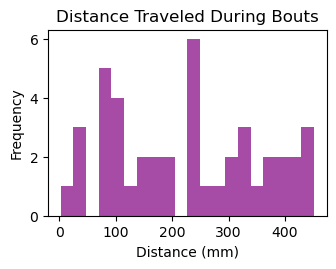

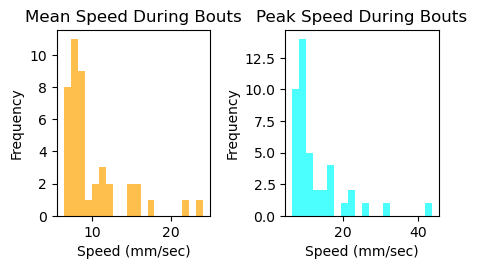

In [25]:
# Plot trajectory, distance, speed, angle, and unwrapped angle for selected fish_ids
selected_fish_ids = [2,4,6]  # Choose 3 fish_ids
for fish_id in selected_fish_ids:
    fish_data = derived_metrics_df[derived_metrics_df['fish_id'] == fish_id]
    
    # Trajectory plot
    plt.figure(figsize=(12, 6))
    plt.scatter(
        fish_data['centroid_x'] / PIX_PER_MM, 
        fish_data['centroid_y'] / PIX_PER_MM, 
        c=fish_data['relative_time'], 
        cmap='viridis', 
        s=20, 
        alpha=0.85
    )
    plt.colorbar(label='Time (s)')
    plt.title(f'Fish Trajectory for Fish ID: {fish_id}')
    plt.xlabel('X Position (mm)')
    plt.ylabel('Y Position (mm)')
    plt.plot(
        fish_data['centroid_x'] / PIX_PER_MM, 
        fish_data['centroid_y'] / PIX_PER_MM, 
        color='gray', 
        linewidth=1.5, 
        alpha=0.3
    )
    plt.show()
    
    # Trajectory plot colored by cumulative speed
    plt.figure(figsize=(12, 6))
    plt.scatter(
        fish_data['centroid_x'] / PIX_PER_MM, 
        fish_data['centroid_y'] / PIX_PER_MM, 
        c=fish_data['speed'], 
        cmap='viridis', 
        s=20, 
        alpha=0.85
    )
    plt.colorbar(label='Speed (mm/sec)')
    plt.title(f'Fish Trajectory (Colored by Speed) for Fish ID: {fish_id}')
    plt.xlabel('X Position (mm)')
    plt.ylabel('Y Position (mm)')
    plt.plot(
        fish_data['centroid_x'] / PIX_PER_MM, 
        fish_data['centroid_y'] / PIX_PER_MM, 
        color='gray', 
        linewidth=1.5, 
        alpha=0.3
    )
    plt.show()
    
    # Distance plot
    plt.figure()
    plt.plot(fish_data['relative_time'], fish_data['distance'], label='Distance (mm)')
    plt.title(f'Distance for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Distance (mm)')
    plt.legend()
    plt.show()
    
    # Speed plot
    plt.figure()
    plt.plot(fish_data['relative_time'], fish_data['speed'], label='Speed (mm/sec)')
    plt.title(f'Speed for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Speed (mm/sec)')
    plt.legend()
    plt.show()
    
    # Smoothed speed plot
    plt.figure()
    plt.plot(fish_data['relative_time'], fish_data['smoothed_speed'], label='Smoothed Speed (mm/sec)', color='orange')
    plt.title(f'Smoothed Speed for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Smoothed Speed (mm/sec)')
    plt.legend()
    plt.show()
    
    # Angle plot
    plt.figure()
    plt.plot(fish_data['relative_time'], fish_data['angle'], label='Angle')
    plt.title(f'Angle for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Angle')
    plt.legend()
    plt.show()
    
    # Unwrapped angle plot
    plt.figure()
    plt.plot(fish_data['relative_time'], fish_data['unwrapped_angle'], label='Unwrapped Angle')
    plt.title(f'Unwrapped Angle for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Unwrapped Angle')
    plt.legend()
    plt.show()

# Print bout statistics and plot bout detection and histograms for selected fish_ids
for fish_id in selected_fish_ids:
    fish_data = derived_metrics_df[derived_metrics_df['fish_id'] == fish_id]
    fish_bout_data = bout_properties_df[bout_properties_df['fish_id'] == fish_id]
    
    # Print bout statistics
    print_bout_statistics(fish_bout_data, fish_id)
    
    # Plot bout detection
    plot_bout_detection(fish_data, fish_bout_data, fish_id)
    plt.show()
    
    # Plot histograms of bout properties for the current fish
    print(f"Histograms for Fish ID: {fish_id}")
    plot_histograms(fish_bout_data)

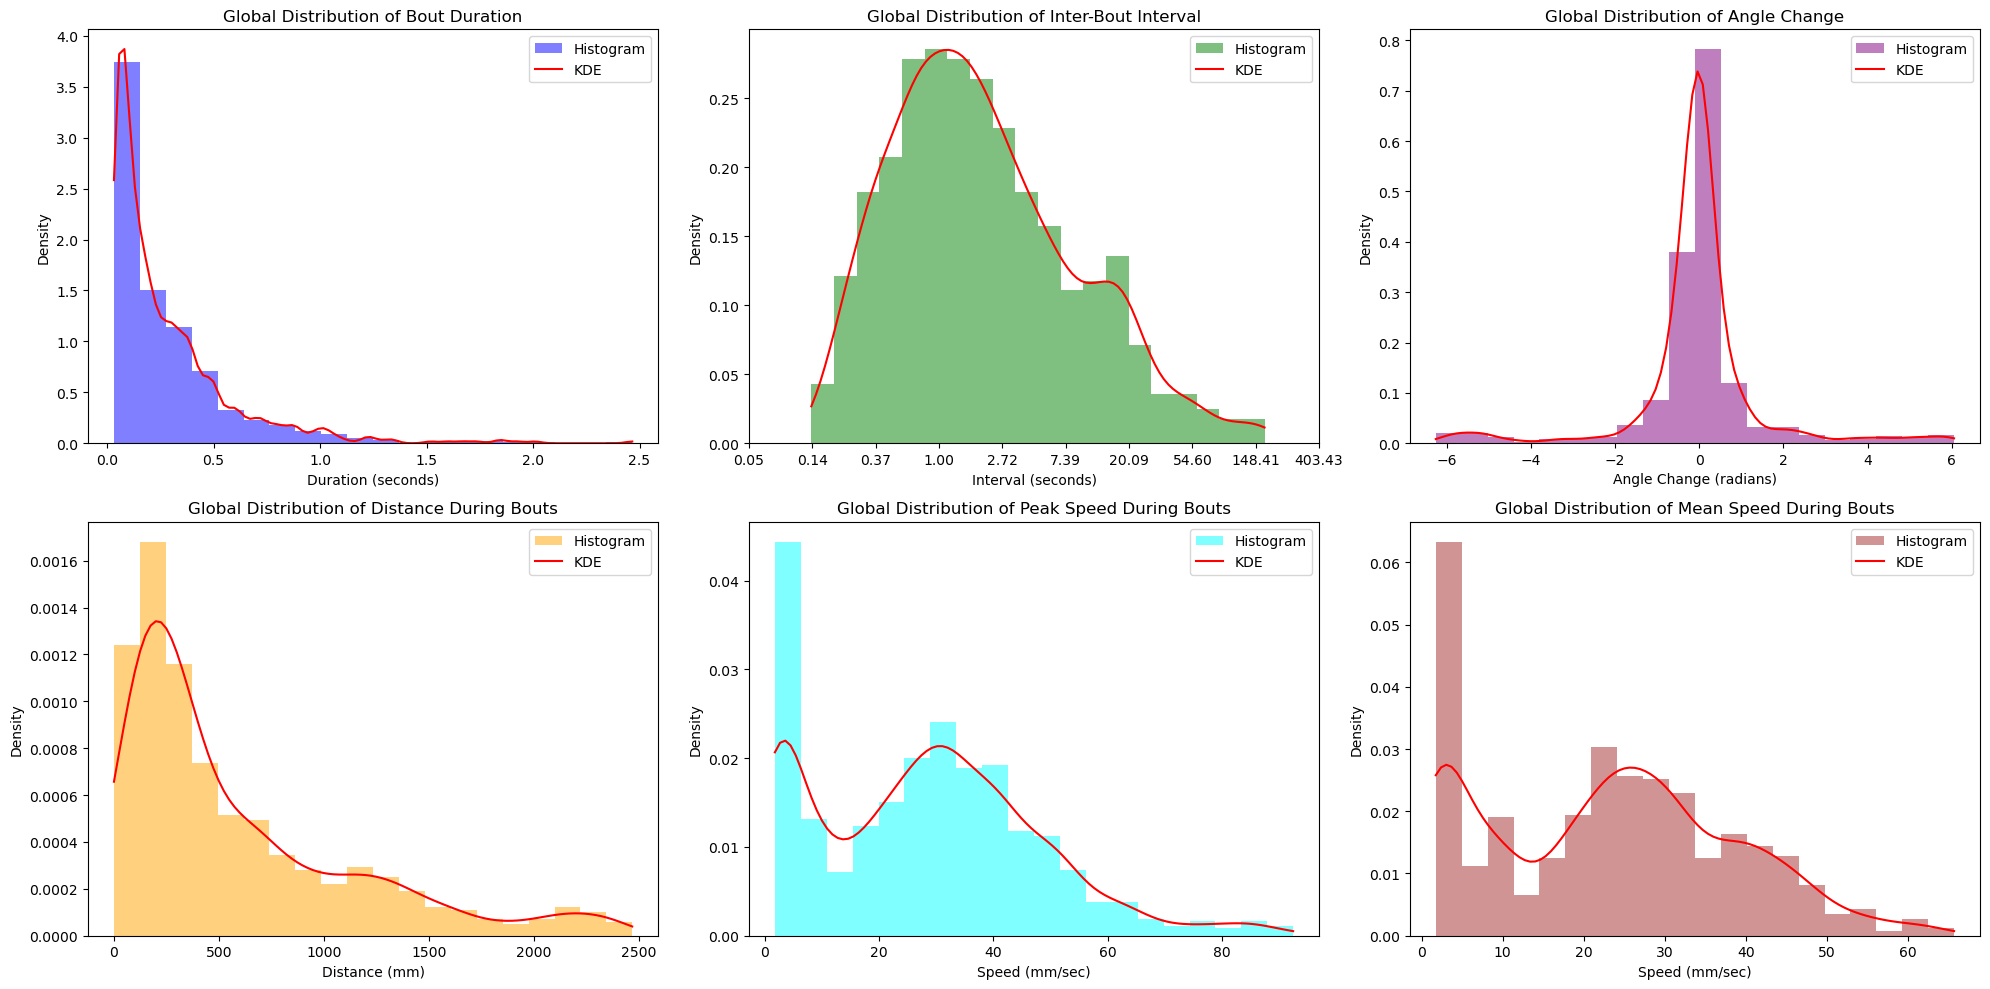

In [26]:
from scipy.stats import gaussian_kde

# Extract bout properties
bout_duration = bout_properties_df['duration'].values
log_intervals = bout_properties_df['log_inter_bout_interval'].dropna().values  # Use precomputed log-transformed values
angle_change = bout_properties_df['angle_change'].values
distance_during_bouts = bout_properties_df['distance_during_bout'].values  # Distance during bouts
peak_speed = bout_properties_df['peak_speed'].values  # Peak speed during bouts
mean_speed = bout_properties_df['mean_speed'].values  # Mean speed during bouts

# --- Plot Global Histograms and Perform KDE ---
plt.figure(figsize=(20, 10))

# Bout duration
plt.subplot(2, 3, 1)
# Histogram
plt.hist(bout_duration, bins=20, density=True, alpha=0.5, color='blue', label='Histogram')
# KDE
kde_duration = gaussian_kde(bout_duration, bw_method=0.1)
x_duration = np.linspace(min(bout_duration), max(bout_duration), 100)
pdf_duration = kde_duration(x_duration)
plt.plot(x_duration, pdf_duration, color='red', label='KDE')
plt.title('Global Distribution of Bout Duration')
plt.xlabel('Duration (seconds)')
plt.ylabel('Density')
plt.legend()

# Inter-bout interval (log-transformed but displayed in original units)
plt.subplot(2, 3, 2)
# Histogram
plt.hist(log_intervals, bins=20, density=True, alpha=0.5, color='green', label='Histogram')
# KDE
kde_intervals = gaussian_kde(log_intervals, bw_method=0.2)
x_intervals = np.linspace(min(log_intervals), max(log_intervals), 100)
pdf_intervals = kde_intervals(x_intervals)
plt.plot(x_intervals, pdf_intervals, color='red', label='KDE')

# Adjust x-axis ticks to show original units
original_ticks = np.exp(plt.xticks()[0])  # Convert log-transformed ticks back to original scale
plt.xticks(np.log(original_ticks), [f"{tick:.2f}" for tick in original_ticks])  # Set ticks and labels

plt.title('Global Distribution of Inter-Bout Interval')
plt.xlabel('Interval (seconds)')
plt.ylabel('Density')
plt.legend()

# Angle change
plt.subplot(2, 3, 3)
# Histogram
plt.hist(angle_change, bins=20, density=True, alpha=0.5, color='purple', label='Histogram')
# KDE
kde_angle = gaussian_kde(angle_change, bw_method=0.2)
x_angle = np.linspace(min(angle_change), max(angle_change), 100)
pdf_angle = kde_angle(x_angle)
plt.plot(x_angle, pdf_angle, color='red', label='KDE')
plt.title('Global Distribution of Angle Change')
plt.xlabel('Angle Change (radians)')
plt.ylabel('Density')
plt.legend()

# Distance during bouts
plt.subplot(2, 3, 4)
# Histogram
plt.hist(distance_during_bouts, bins=20, density=True, alpha=0.5, color='orange', label='Histogram')
# KDE
kde_distance = gaussian_kde(distance_during_bouts, bw_method=0.2)
x_distance = np.linspace(min(distance_during_bouts), max(distance_during_bouts), 100)
pdf_distance = kde_distance(x_distance)
plt.plot(x_distance, pdf_distance, color='red', label='KDE')
plt.title('Global Distribution of Distance During Bouts')
plt.xlabel('Distance (mm)')
plt.ylabel('Density')
plt.legend()

# Peak speed during bouts
plt.subplot(2, 3, 5)
# Histogram
plt.hist(peak_speed, bins=20, density=True, alpha=0.5, color='cyan', label='Histogram')
# KDE
kde_peak_speed = gaussian_kde(peak_speed, bw_method=0.2)
x_peak_speed = np.linspace(min(peak_speed), max(peak_speed), 100)
pdf_peak_speed = kde_peak_speed(x_peak_speed)
plt.plot(x_peak_speed, pdf_peak_speed, color='red', label='KDE')
plt.title('Global Distribution of Peak Speed During Bouts')
plt.xlabel('Speed (mm/sec)')
plt.ylabel('Density')
plt.legend()

# Mean speed during bouts
plt.subplot(2, 3, 6)
# Histogram
plt.hist(mean_speed, bins=20, density=True, alpha=0.5, color='brown', label='Histogram')
# KDE
kde_mean_speed = gaussian_kde(mean_speed, bw_method=0.2)
x_mean_speed = np.linspace(min(mean_speed), max(mean_speed), 100)
pdf_mean_speed = kde_mean_speed(x_mean_speed)
plt.plot(x_mean_speed, pdf_mean_speed, color='red', label='KDE')
plt.title('Global Distribution of Mean Speed During Bouts')
plt.xlabel('Speed (mm/sec)')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

Estimated bouts_per_path: 37


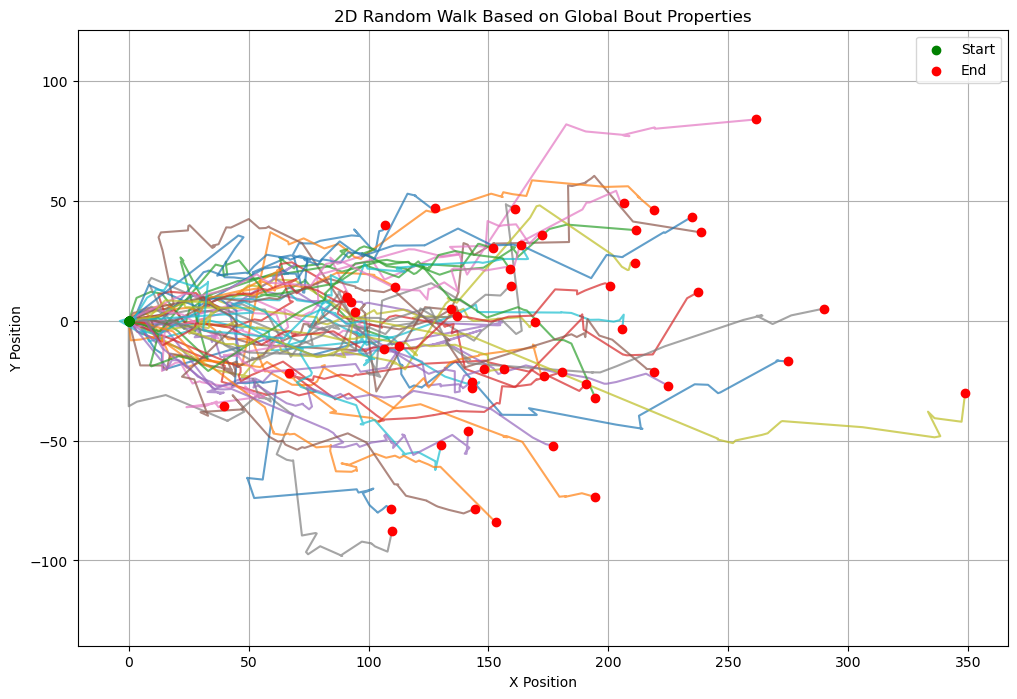

In [27]:
# Simulate 2D random walk based on global bout properties

# Assume KDEs for bout properties are already computed
kde_distance = gaussian_kde(bout_properties_df['distance_during_bout'].values)  # KDE for distance during bouts
kde_log_intervals = gaussian_kde(bout_properties_df['log_inter_bout_interval'].dropna().values)  # KDE for log inter-bout intervals
kde_angle = gaussian_kde(bout_properties_df['angle_change'].values)  # KDE for angle change
kde_duration = gaussian_kde(bout_properties_df['duration'].values)  # KDE for bout duration
kde_mean_speed = gaussian_kde(bout_properties_df['mean_speed'].values)  # KDE for mean speed

# Parameters for the simulation
paths = 50  # Number of independent random walk simulations

# Calculate bouts_per_path dynamically using num_bouts_detected
# Group by fish_id and calculate the mean number of bouts detected per fish
mean_bouts_per_fish = bout_properties_df.groupby('fish_id')['num_bouts_detected'].mean()

# Calculate the overall mean number of bouts across all fish
bouts_per_path = int(mean_bouts_per_fish.mean())
print(f"Estimated bouts_per_path: {bouts_per_path}")


# Resample from KDEs
resampled_distance = kde_distance.resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)  # Step sizes
resampled_log_intervals = kde_log_intervals.resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)  # Log inter-bout intervals
resampled_angle = kde_angle.resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)  # Directions (angles)
resampled_duration = kde_duration.resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)  # Bout durations
resampled_mean_speed = kde_mean_speed.resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)  # Mean speeds

# Initialize positions (start at origin for all paths)
X = np.zeros((paths, bouts_per_path + 1))
Y = np.zeros((paths, bouts_per_path + 1))
time = np.zeros((paths, bouts_per_path + 1))  # Track time for each path


# Simulate 2D random walk with bouts
for path in range(paths):
    for bout in range(bouts_per_path):
        # Bout duration
        bout_duration = resampled_duration[path, bout]
        
        # Speed during the bout
        speed = resampled_mean_speed[path, bout]
        
        # Step size (distance traveled during the bout)
        step_size = speed * bout_duration  # Calculate step size based on speed and duration
        
        # Direction (angle of movement)
        angle = resampled_angle[path, bout]
        
        # Inter-bout interval (time between bouts)
        inter_bout_interval = np.exp(resampled_log_intervals[path, bout])  # Convert log interval back to original scale
        
        # Update position
        X[path, bout + 1] = X[path, bout] + step_size * np.cos(angle)
        Y[path, bout + 1] = Y[path, bout] + step_size * np.sin(angle)
        
        # Update time
        time[path, bout + 1] = time[path, bout] + bout_duration + inter_bout_interval

# Plot the 2D random walk paths
fig, ax = plt.subplots(figsize=(12, 8))
for path in range(paths):
    ax.plot(X[path, :], Y[path, :], alpha=0.7)
ax.scatter(X[:, 0], Y[:, 0], color='green', label='Start', zorder=5)  # Start points
ax.scatter(X[:, -1], Y[:, -1], color='red', label='End', zorder=5)    # End points
ax.set_title("2D Random Walk Based on Global Bout Properties")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.legend()
ax.grid()
plt.axis('equal')
plt.show()

In [ ]:
#dark_df[dark_df['fish_id']==9].head(n=100)

t_display     t_local    latency  centroid_x  centroid_y  \
18006  15898514654384  300.047361  20.022448   38.447688   48.720027   
18007  15898527424754  300.060131  16.015602   38.447021   48.728062   
18008  15898544087643  300.076794  15.901275   38.449168   48.721507   
18009  15898568753335  300.101460  23.789751   38.462479   48.731436   
18010  15898581770480  300.114477  20.029680   38.462681   48.727237   
...               ...         ...        ...         ...         ...   
18101  15900099652054  301.632359  21.670358   38.466858   48.719064   
18102  15900116778772  301.649485  23.068436   38.453469   48.741983   
18103  15900133177865  301.665884  21.641737   38.452162   48.717099   
18104  15900150087900  301.682794  21.774556   38.448523   48.734808   
18105  15900162475321  301.695182  17.384761   38.451888   48.729428   

          pc1_x     pc1_y     pc2_x     pc2_y  left_eye_x  ...  fish_id  dpf  \
18006  0.811639 -0.584159  0.584159  0.811639   17.989422  ...        9    9   
18007  0.815661 -0.578530  0.578530  0.815661   17.391008  ...        9    9   
18008  0.819271 -0.573407  0.573407  0.819271   17.575836  ...        9    9   
18009  0.821986 -0.569508  0.569508  0.821986   16.875126  ...        9    9   
18010  0.810957 -0.585105  0.585105  0.810957   18.013859  ...        9    9   
...         ...       ...       ...       ...         ...  ...      ...  ...   
18101  0.819212 -0.573491  0.573491  0.819212   17.374683  ...        9    9   
18102  0.822590 -0.568635  0.568635  0.822590   16.502171  ...        9    9   
18103  0.815906 -0.578185  0.578185  0.815906   17.583286  ...        9    9   
18104  0.819710 -0.572779  0.572779  0.819710   16.679401  ...        9    9   
18105  0.822572 -0.568660  0.568660  0.822572   17.469343  ...        9    9   

                      date  relative_time  relative_index  distance_mm  \
18006  2024-08-27 16:03:14       0.004607           18006   241.112198   
18007  2024-08-27 16:03:14       0.017378           18007   241.120260   
18008  2024-08-27 16:03:14       0.034041           18008   241.127158   
18009  2024-08-27 16:03:14       0.058706           18009   241.143764   
18010  2024-08-27 16:03:14       0.071724           18010   241.147969   
...                    ...            ...             ...          ...   
18101  2024-08-27 16:03:14       1.589605           18101   242.779063   
18102  2024-08-27 16:03:14       1.606732           18102   242.805607   
18103  2024-08-27 16:03:14       1.623131           18103   242.830526   
18104  2024-08-27 16:03:14       1.640041           18104   242.848605   
18105  2024-08-27 16:03:14       1.652428           18105   242.854951   

       displacement     angle  unwrapped_angle  speed_mm_per_sec  
18006      4.417740 -0.623844        -0.623844         -0.803486  
18007      4.417780 -0.616926        -0.616926      18881.227441  
18008      4.419343 -0.610658        -0.610658      14470.909450  
18009      4.433476 -0.605907        -0.605907       9776.484863  
18010      4.433305 -0.625010        -0.625010      18525.411610  
...             ...       ...              ...               ...  
18101      4.436755 -0.610761        -0.610761      14868.384970  
18102      4.425455 -0.604845        -0.604845      14177.007371  
18103      4.421944 -0.616502        -0.616502      14807.558295  
18104      4.419878 -0.609892        -0.609892      14361.212425  
18105      4.422749 -0.604876        -0.604876      19604.964669  

[100 rows x 117 columns]

In [29]:
phototaxis_df = pd.read_csv(r'.\processed_data\phototaxis_data_20250409.csv')

# Calculate derived metrics for all fish
derived_metrics_list = []

# Group by fish_id
grouped_df = phototaxis_df.groupby('fish_id')
for fish_id, group in grouped_df:
    # Calculate derived metrics
    group['relative_time'] = get_relative_time(group)
    group['relative_index'] = get_relative_index(group)
    group['distance'] = get_cumulative_distance(group)
    group['angle'], group['unwrapped_angle'] = get_heading_angle(group)
    group['speed'] = get_cumulative_speed(group)
    # Calculate smoothed speed
    group['smoothed_speed'] = smooth_data(group['speed'], method='gaussian', sigma=2)
    # Append the processed group to the list
    derived_metrics_list.append(group)

# Combine all derived metrics into a single DataFrame
derived_metrics_df = pd.concat(derived_metrics_list, ignore_index=True)

# Save the derived metrics DataFrame to a CSV file
date_str = datetime.now().strftime('%Y%m%d')
derived_metrics_path = rf'.\processed_data\derived_metrics_phototaxis_{date_str}.csv'
derived_metrics_df.to_csv(derived_metrics_path, index=False)
print(f"Derived metrics saved to {derived_metrics_path}")

# Load the derived metrics DataFrame
derived_metrics_df = pd.read_csv(derived_metrics_path)

# Initialize an empty list to store bout properties for all fish
bout_properties_list = []

# Group by fish_id
grouped_df = derived_metrics_df.groupby('fish_id')
for fish_id, group in grouped_df:
    # Discard the first point in the trajectory
    group = group.dropna(subset=['speed', 'distance'])
    
    # Detect bouts
    bout_df = detect_fish_bouts_2(group, fish_id=fish_id, method='gaussian', sigma=2)
    
    # Add fish_id to bout_df
    bout_df['fish_id'] = fish_id
    
    # Append bout_df to the list
    bout_properties_list.append(bout_df)

# Combine all bout properties into a single DataFrame
bout_properties_df = pd.concat(bout_properties_list, ignore_index=True)
# Add a small constant (e.g., 1e-6) to avoid issues with log(0)
bout_properties_df['log_inter_bout_interval'] = np.log(bout_properties_df['inter_bout_interval'] + 1e-6)
# Save the bout properties DataFrame to a CSV file
bout_properties_path = rf'.\processed_data\bout_properties_phototaxis_{date_str}.csv'
bout_properties_df.to_csv(bout_properties_path, index=False)
print(f"Bout properties saved to {bout_properties_path}")

bout_properties_df = pd.read_csv(bout_properties_path)

Derived metrics saved to .\processed_data\derived_metrics_phototaxis_20250416.csv
Bout properties saved to .\processed_data\bout_properties_phototaxis_20250416.csv


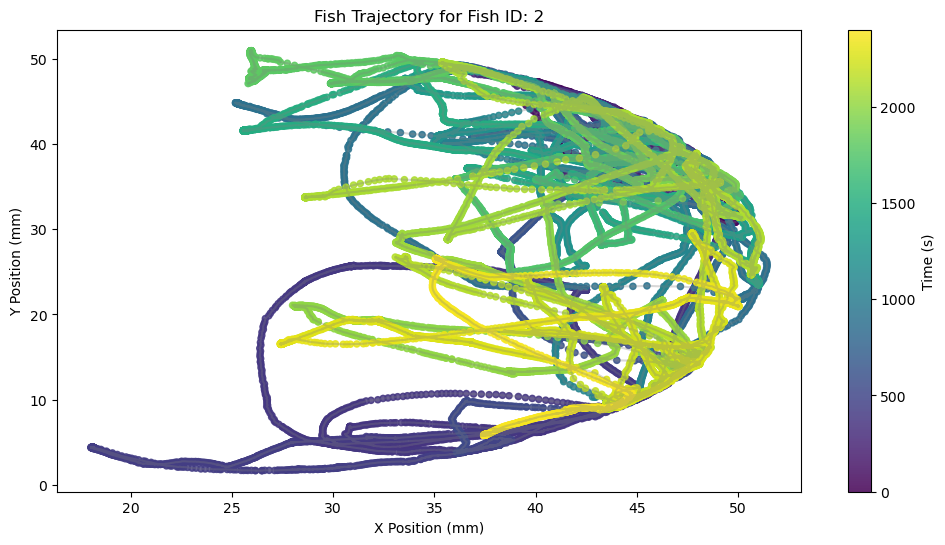

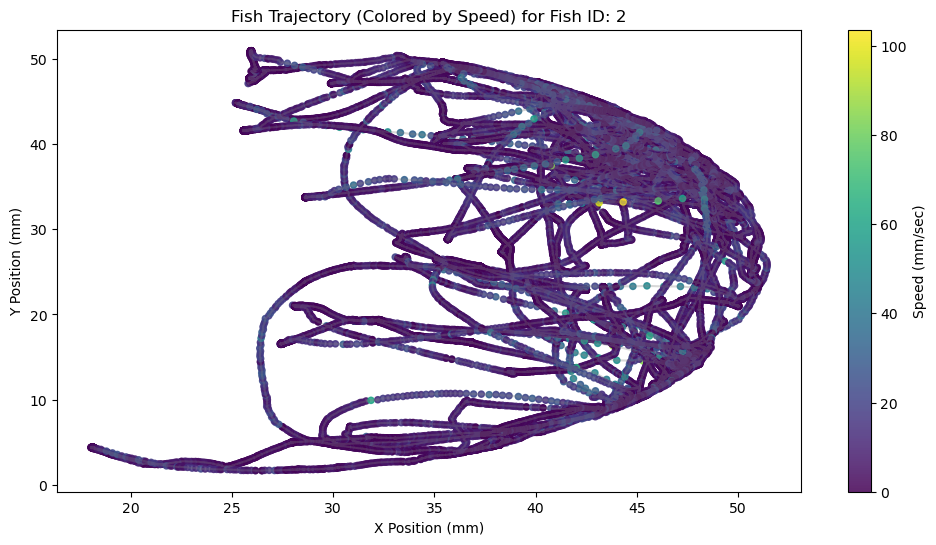

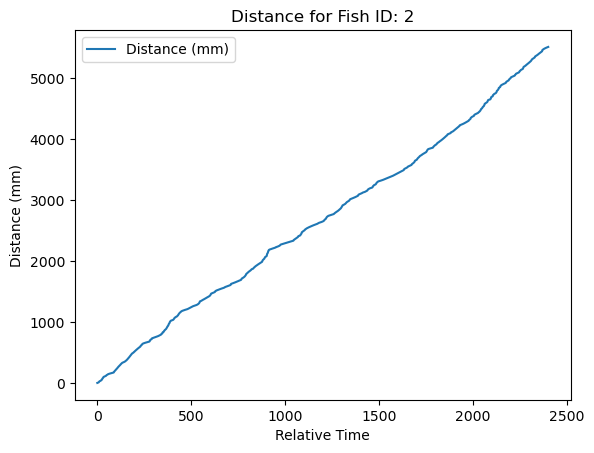

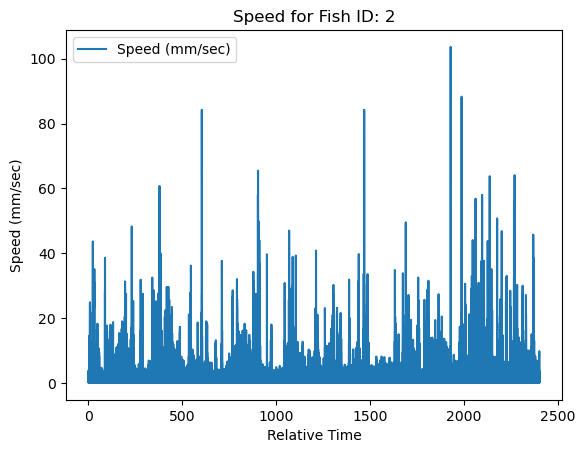

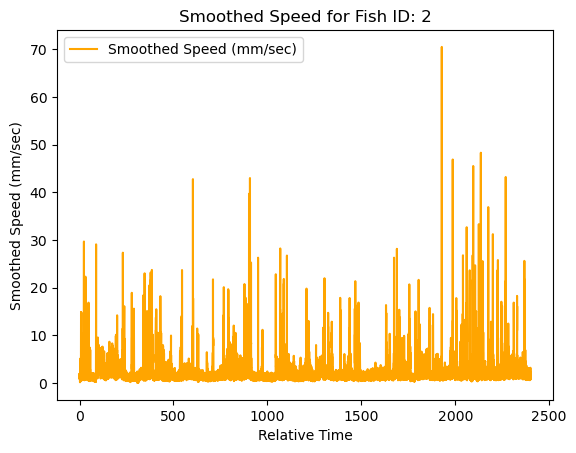

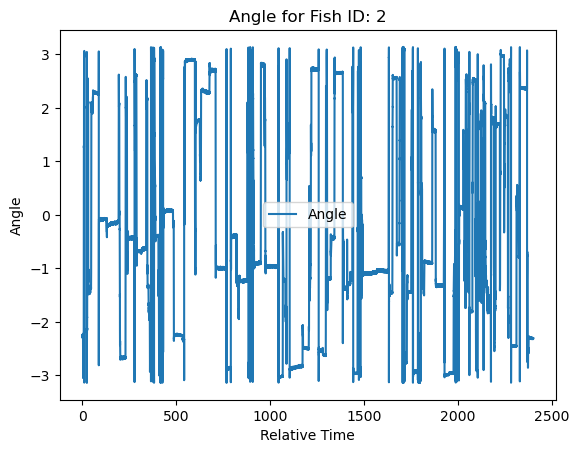

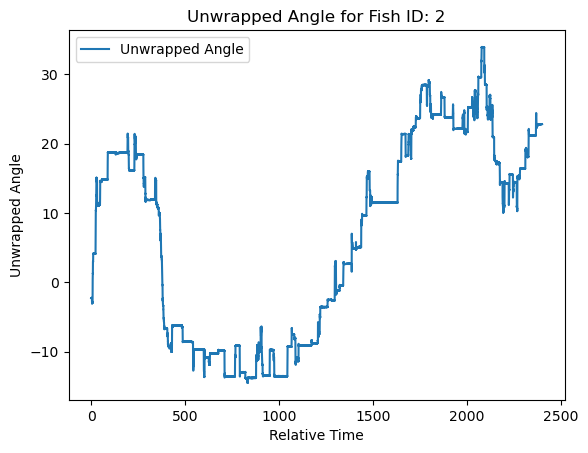

Total Number of bouts detected: 277
Average bout duration: 0.30 time units
Average bout peak speed: 14.91 mm/sec
Average bout mean speed: 11.24 mm/sec
Average inter-bout interval: 8.88 time units
Average angle change: -0.08 radians
Average distance traveled: 2760.06 mm

Top 5 bouts by peak speed:
     bout_id   start_time  duration  peak_speed
196      205  1927.880482  0.282712   70.514679
237      247  2135.863619  0.733697   48.310966
201      210  1986.184256  0.497096   46.889319
223      233  2095.197663  0.375862   45.523552
258      268  2268.082990  0.450264   43.218654


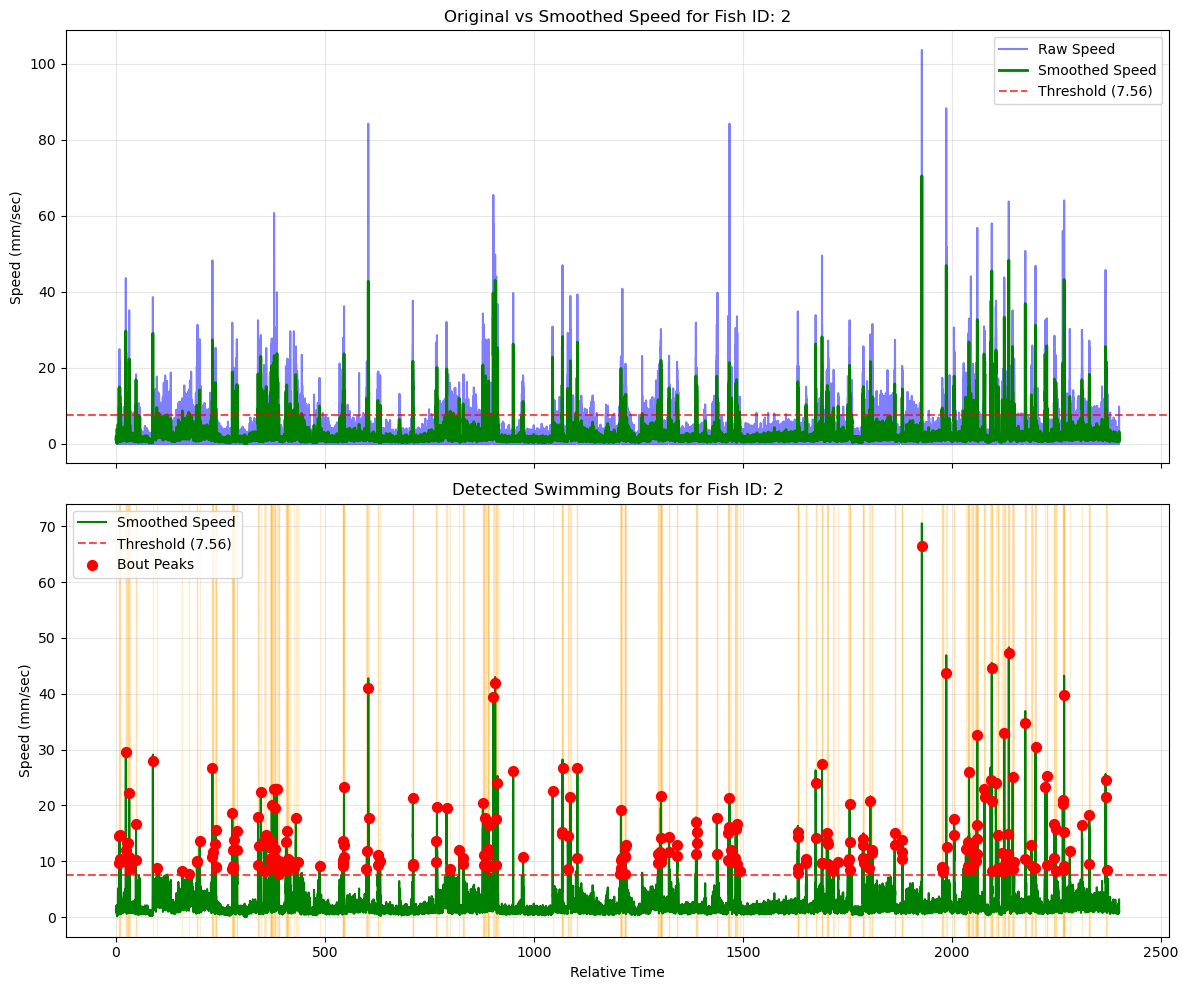

Histograms for Fish ID: 2


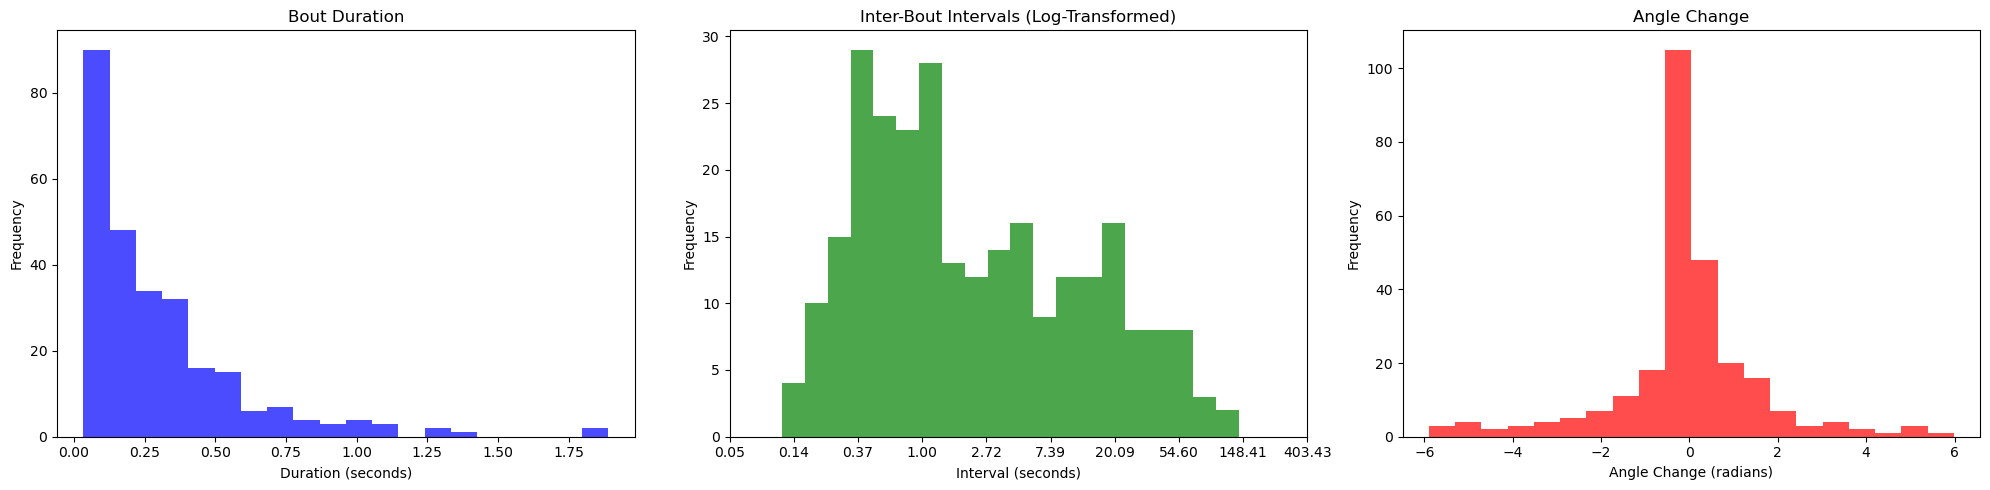

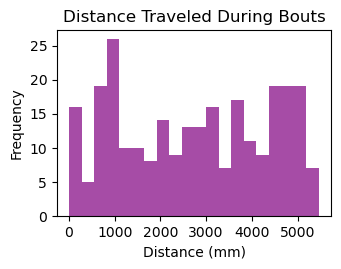

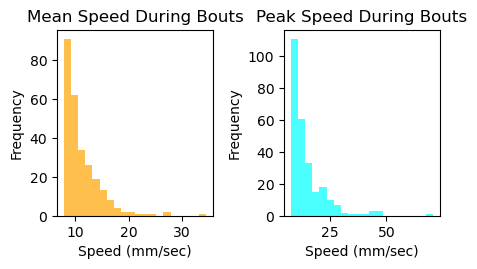

In [36]:
# Plot trajectory, distance, speed, angle, and unwrapped angle for selected fish_ids
selected_fish_ids = [2]  # Choose 3 fish_ids
for fish_id in selected_fish_ids:
    fish_data = derived_metrics_df[derived_metrics_df['fish_id'] == fish_id]
    
    # Trajectory plot
    plt.figure(figsize=(12, 6))
    plt.scatter(
        fish_data['centroid_x'] / PIX_PER_MM, 
        fish_data['centroid_y'] / PIX_PER_MM, 
        c=fish_data['relative_time'], 
        cmap='viridis', 
        s=20, 
        alpha=0.85
    )
    plt.colorbar(label='Time (s)')
    plt.title(f'Fish Trajectory for Fish ID: {fish_id}')
    plt.xlabel('X Position (mm)')
    plt.ylabel('Y Position (mm)')
    plt.plot(
        fish_data['centroid_x'] / PIX_PER_MM, 
        fish_data['centroid_y'] / PIX_PER_MM, 
        color='gray', 
        linewidth=1.5, 
        alpha=0.3
    )
    plt.show()
    
    # Trajectory plot colored by cumulative speed
    plt.figure(figsize=(12, 6))
    plt.scatter(
        fish_data['centroid_x'] / PIX_PER_MM, 
        fish_data['centroid_y'] / PIX_PER_MM, 
        c=fish_data['speed'], 
        cmap='viridis', 
        s=20, 
        alpha=0.85
    )
    plt.colorbar(label='Speed (mm/sec)')
    plt.title(f'Fish Trajectory (Colored by Speed) for Fish ID: {fish_id}')
    plt.xlabel('X Position (mm)')
    plt.ylabel('Y Position (mm)')
    plt.plot(
        fish_data['centroid_x'] / PIX_PER_MM, 
        fish_data['centroid_y'] / PIX_PER_MM, 
        color='gray', 
        linewidth=1.5, 
        alpha=0.3
    )
    plt.show()
    
    # Distance plot
    plt.figure()
    plt.plot(fish_data['relative_time'], fish_data['distance'], label='Distance (mm)')
    plt.title(f'Distance for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Distance (mm)')
    plt.legend()
    plt.show()
    
    # Speed plot
    plt.figure()
    plt.plot(fish_data['relative_time'], fish_data['speed'], label='Speed (mm/sec)')
    plt.title(f'Speed for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Speed (mm/sec)')
    plt.legend()
    plt.show()
    
    # Smoothed speed plot
    plt.figure()
    plt.plot(fish_data['relative_time'], fish_data['smoothed_speed'], label='Smoothed Speed (mm/sec)', color='orange')
    plt.title(f'Smoothed Speed for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Smoothed Speed (mm/sec)')
    plt.legend()
    plt.show()
    
    # Angle plot
    plt.figure()
    plt.plot(fish_data['relative_time'], fish_data['angle'], label='Angle')
    plt.title(f'Angle for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Angle')
    plt.legend()
    plt.show()
    
    # Unwrapped angle plot
    plt.figure()
    plt.plot(fish_data['relative_time'], fish_data['unwrapped_angle'], label='Unwrapped Angle')
    plt.title(f'Unwrapped Angle for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Unwrapped Angle')
    plt.legend()
    plt.show()

# Print bout statistics and plot bout detection and histograms for selected fish_ids
for fish_id in selected_fish_ids:
    fish_data = derived_metrics_df[derived_metrics_df['fish_id'] == fish_id]
    fish_bout_data = bout_properties_df[bout_properties_df['fish_id'] == fish_id]
    
    # Print bout statistics
    print_bout_statistics(fish_bout_data, fish_id)
    
    # Plot bout detection
    plot_bout_detection(fish_data, fish_bout_data, fish_id)
    plt.show()
    
    # Plot histograms of bout properties for the current fish
    print(f"Histograms for Fish ID: {fish_id}")
    plot_histograms(fish_bout_data)

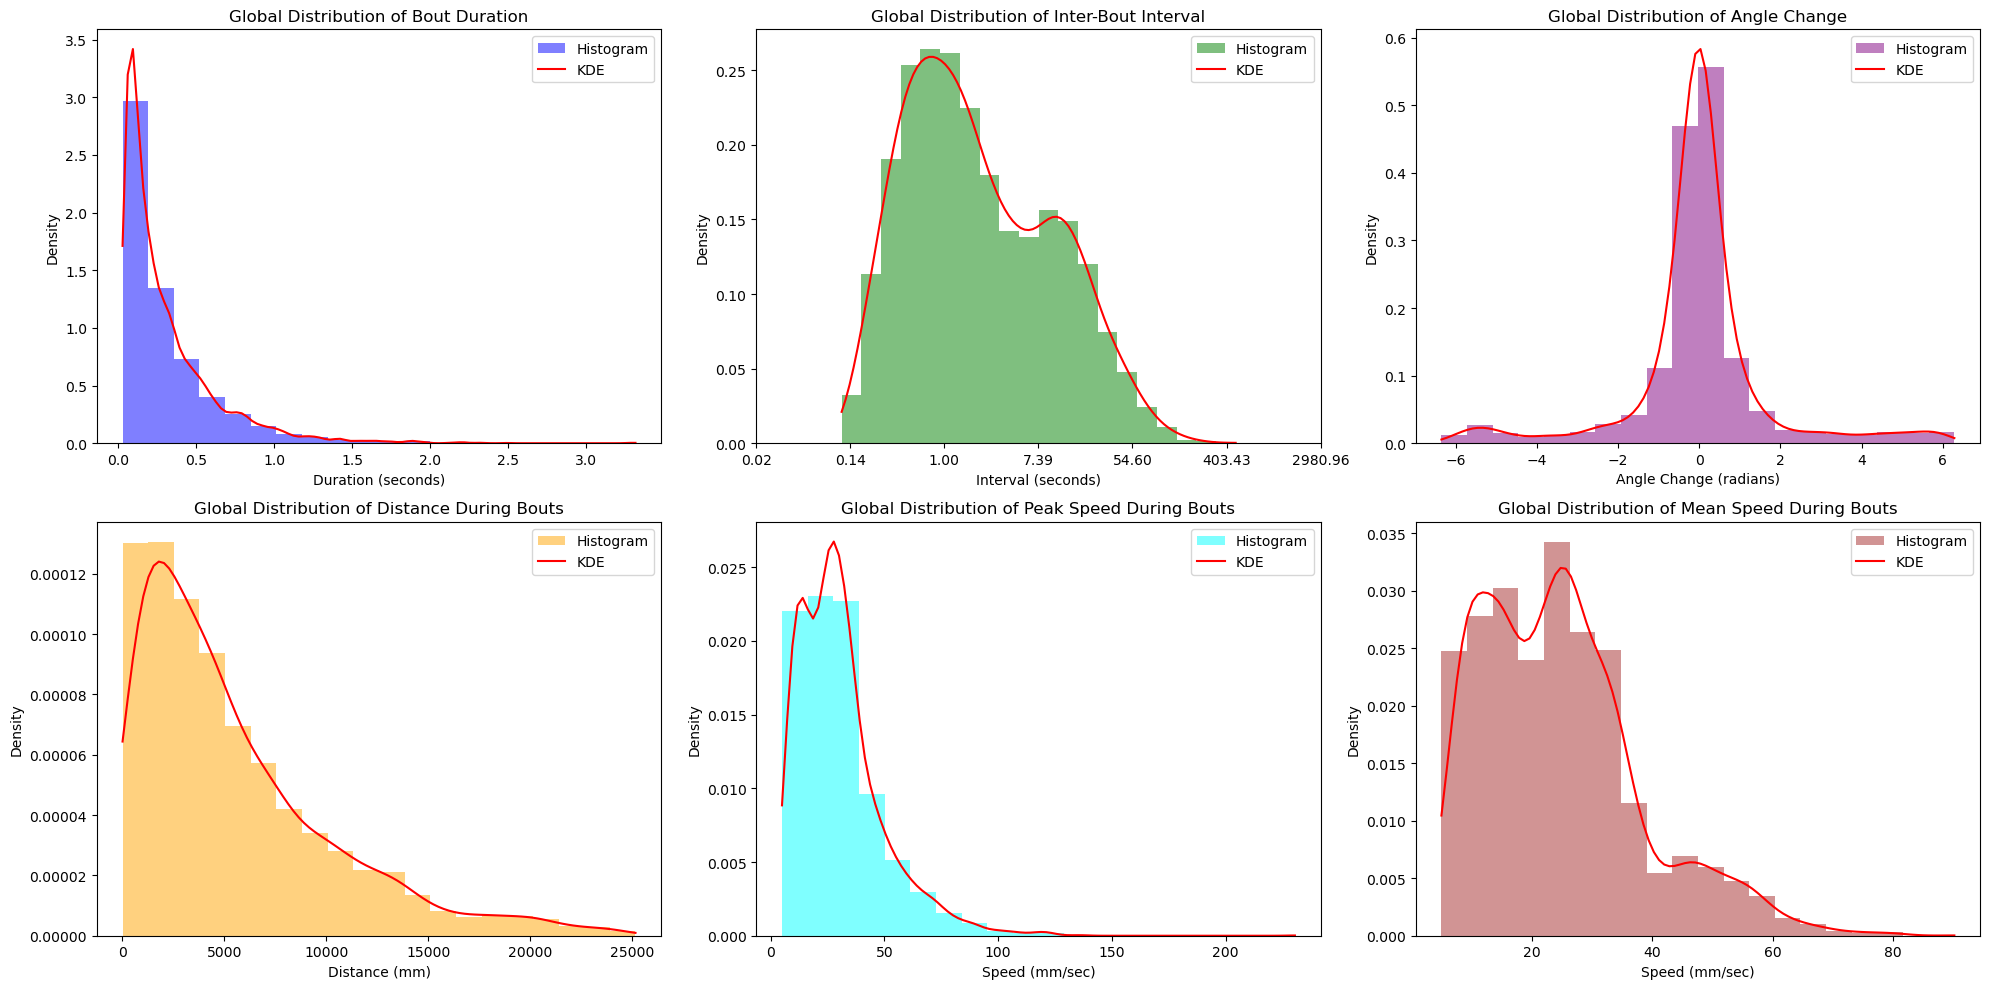

In [37]:
from scipy.stats import gaussian_kde

# Extract bout properties
bout_duration = bout_properties_df['duration'].values
log_intervals = bout_properties_df['log_inter_bout_interval'].dropna().values  # Use precomputed log-transformed values
angle_change = bout_properties_df['angle_change'].values
distance_during_bouts = bout_properties_df['distance_during_bout'].values  # Distance during bouts
peak_speed = bout_properties_df['peak_speed'].values  # Peak speed during bouts
mean_speed = bout_properties_df['mean_speed'].values  # Mean speed during bouts

# --- Plot Global Histograms and Perform KDE ---
plt.figure(figsize=(20, 10))

# Bout duration
plt.subplot(2, 3, 1)
# Histogram
plt.hist(bout_duration, bins=20, density=True, alpha=0.5, color='blue', label='Histogram')
# KDE
kde_duration = gaussian_kde(bout_duration, bw_method=0.1)
x_duration = np.linspace(min(bout_duration), max(bout_duration), 100)
pdf_duration = kde_duration(x_duration)
plt.plot(x_duration, pdf_duration, color='red', label='KDE')
plt.title('Global Distribution of Bout Duration')
plt.xlabel('Duration (seconds)')
plt.ylabel('Density')
plt.legend()

# Inter-bout interval (log-transformed but displayed in original units)
plt.subplot(2, 3, 2)
# Histogram
plt.hist(log_intervals, bins=20, density=True, alpha=0.5, color='green', label='Histogram')
# KDE
kde_intervals = gaussian_kde(log_intervals, bw_method=0.2)
x_intervals = np.linspace(min(log_intervals), max(log_intervals), 100)
pdf_intervals = kde_intervals(x_intervals)
plt.plot(x_intervals, pdf_intervals, color='red', label='KDE')

# Adjust x-axis ticks to show original units
original_ticks = np.exp(plt.xticks()[0])  # Convert log-transformed ticks back to original scale
plt.xticks(np.log(original_ticks), [f"{tick:.2f}" for tick in original_ticks])  # Set ticks and labels

plt.title('Global Distribution of Inter-Bout Interval')
plt.xlabel('Interval (seconds)')
plt.ylabel('Density')
plt.legend()

# Angle change
plt.subplot(2, 3, 3)
# Histogram
plt.hist(angle_change, bins=20, density=True, alpha=0.5, color='purple', label='Histogram')
# KDE
kde_angle = gaussian_kde(angle_change, bw_method=0.2)
x_angle = np.linspace(min(angle_change), max(angle_change), 100)
pdf_angle = kde_angle(x_angle)
plt.plot(x_angle, pdf_angle, color='red', label='KDE')
plt.title('Global Distribution of Angle Change')
plt.xlabel('Angle Change (radians)')
plt.ylabel('Density')
plt.legend()

# Distance during bouts
plt.subplot(2, 3, 4)
# Histogram
plt.hist(distance_during_bouts, bins=20, density=True, alpha=0.5, color='orange', label='Histogram')
# KDE
kde_distance = gaussian_kde(distance_during_bouts, bw_method=0.2)
x_distance = np.linspace(min(distance_during_bouts), max(distance_during_bouts), 100)
pdf_distance = kde_distance(x_distance)
plt.plot(x_distance, pdf_distance, color='red', label='KDE')
plt.title('Global Distribution of Distance During Bouts')
plt.xlabel('Distance (mm)')
plt.ylabel('Density')
plt.legend()

# Peak speed during bouts
plt.subplot(2, 3, 5)
# Histogram
plt.hist(peak_speed, bins=20, density=True, alpha=0.5, color='cyan', label='Histogram')
# KDE
kde_peak_speed = gaussian_kde(peak_speed, bw_method=0.2)
x_peak_speed = np.linspace(min(peak_speed), max(peak_speed), 100)
pdf_peak_speed = kde_peak_speed(x_peak_speed)
plt.plot(x_peak_speed, pdf_peak_speed, color='red', label='KDE')
plt.title('Global Distribution of Peak Speed During Bouts')
plt.xlabel('Speed (mm/sec)')
plt.ylabel('Density')
plt.legend()

# Mean speed during bouts
plt.subplot(2, 3, 6)
# Histogram
plt.hist(mean_speed, bins=20, density=True, alpha=0.5, color='brown', label='Histogram')
# KDE
kde_mean_speed = gaussian_kde(mean_speed, bw_method=0.2)
x_mean_speed = np.linspace(min(mean_speed), max(mean_speed), 100)
pdf_mean_speed = kde_mean_speed(x_mean_speed)
plt.plot(x_mean_speed, pdf_mean_speed, color='red', label='KDE')
plt.title('Global Distribution of Mean Speed During Bouts')
plt.xlabel('Speed (mm/sec)')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

Estimated bouts_per_path: 291


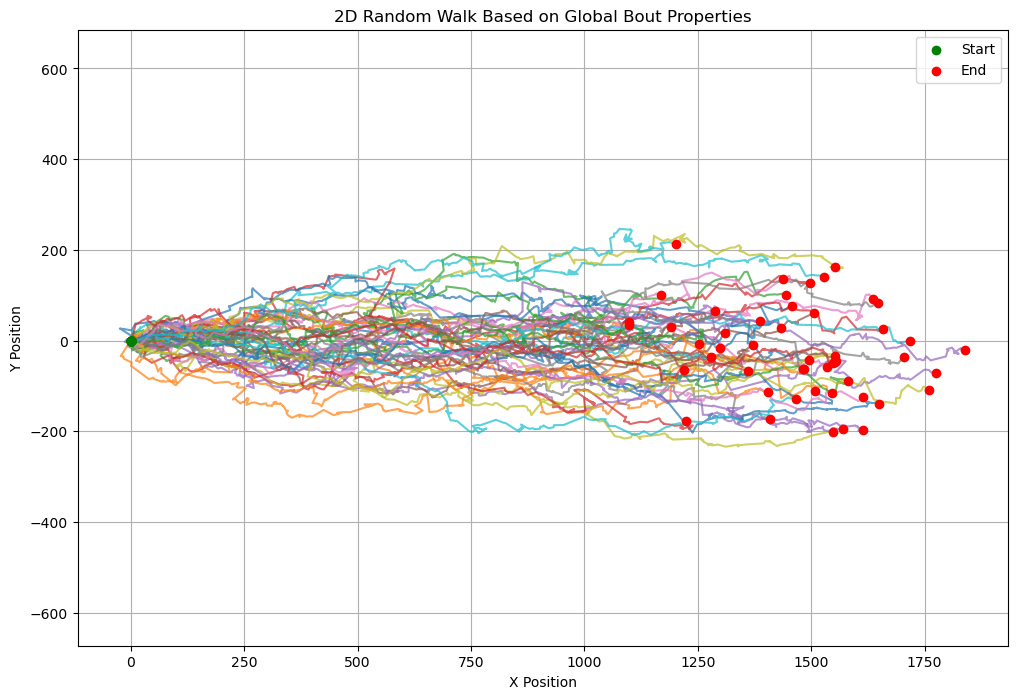

In [38]:
# Simulate 2D random walk based on global bout properties

# Assume KDEs for bout properties are already computed
kde_distance = gaussian_kde(bout_properties_df['distance_during_bout'].values)  # KDE for distance during bouts
kde_log_intervals = gaussian_kde(bout_properties_df['log_inter_bout_interval'].dropna().values)  # KDE for log inter-bout intervals
kde_angle = gaussian_kde(bout_properties_df['angle_change'].values)  # KDE for angle change
kde_duration = gaussian_kde(bout_properties_df['duration'].values)  # KDE for bout duration
kde_mean_speed = gaussian_kde(bout_properties_df['mean_speed'].values)  # KDE for mean speed

# Parameters for the simulation
paths = 50  # Number of independent random walk simulations

# Calculate bouts_per_path dynamically using num_bouts_detected
# Group by fish_id and calculate the mean number of bouts detected per fish
mean_bouts_per_fish = bout_properties_df.groupby('fish_id')['num_bouts_detected'].mean()

# Calculate the overall mean number of bouts across all fish
bouts_per_path = int(mean_bouts_per_fish.mean())
print(f"Estimated bouts_per_path: {bouts_per_path}")


# Resample from KDEs
resampled_distance = kde_distance.resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)  # Step sizes
resampled_log_intervals = kde_log_intervals.resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)  # Log inter-bout intervals
resampled_angle = kde_angle.resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)  # Directions (angles)
resampled_duration = kde_duration.resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)  # Bout durations
resampled_mean_speed = kde_mean_speed.resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)  # Mean speeds

# Initialize positions (start at origin for all paths)
X = np.zeros((paths, bouts_per_path + 1))
Y = np.zeros((paths, bouts_per_path + 1))
time = np.zeros((paths, bouts_per_path + 1))  # Track time for each path


# Simulate 2D random walk with bouts
for path in range(paths):
    for bout in range(bouts_per_path):
        # Bout duration
        bout_duration = resampled_duration[path, bout]
        
        # Speed during the bout
        speed = resampled_mean_speed[path, bout]
        
        # Step size (distance traveled during the bout)
        step_size = speed * bout_duration  # Calculate step size based on speed and duration
        
        # Direction (angle of movement)
        angle = resampled_angle[path, bout]
        
        # Inter-bout interval (time between bouts)
        inter_bout_interval = np.exp(resampled_log_intervals[path, bout])  # Convert log interval back to original scale
        
        # Update position
        X[path, bout + 1] = X[path, bout] + step_size * np.cos(angle)
        Y[path, bout + 1] = Y[path, bout] + step_size * np.sin(angle)
        
        # Update time
        time[path, bout + 1] = time[path, bout] + bout_duration + inter_bout_interval

# Plot the 2D random walk paths
fig, ax = plt.subplots(figsize=(12, 8))
for path in range(paths):
    ax.plot(X[path, :], Y[path, :], alpha=0.7)
ax.scatter(X[:, 0], Y[:, 0], color='green', label='Start', zorder=5)  # Start points
ax.scatter(X[:, -1], Y[:, -1], color='red', label='End', zorder=5)    # End points
ax.set_title("2D Random Walk Based on Global Bout Properties")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.legend()
ax.grid()
plt.axis('equal')
plt.show()

In [10]:
print(phototaxis.columns)

Index(['image_index', 'time', 'angle', 'angle_unwrapped', 'polarity',
       'fish_id', 'dpf'],
      dtype='object')


In [12]:
phototaxis.shape

(144013, 7)

In [13]:
phototaxis.isnull().any()

image_index        False
time               False
angle              False
angle_unwrapped    False
polarity           False
fish_id            False
dpf                False
dtype: bool

In [14]:
data_filtered.isnull().sum()

t_display                             0
t_local                               0
latency                               0
centroid_x                            0
centroid_y                            0
                                     ..
looming_center_mm_x                   0
looming_center_mm_y                   0
looming_period_sec                    0
looming_expansion_time_sec            0
looming_expansion_speed_mm_per_sec    0
Length: 107, dtype: int64

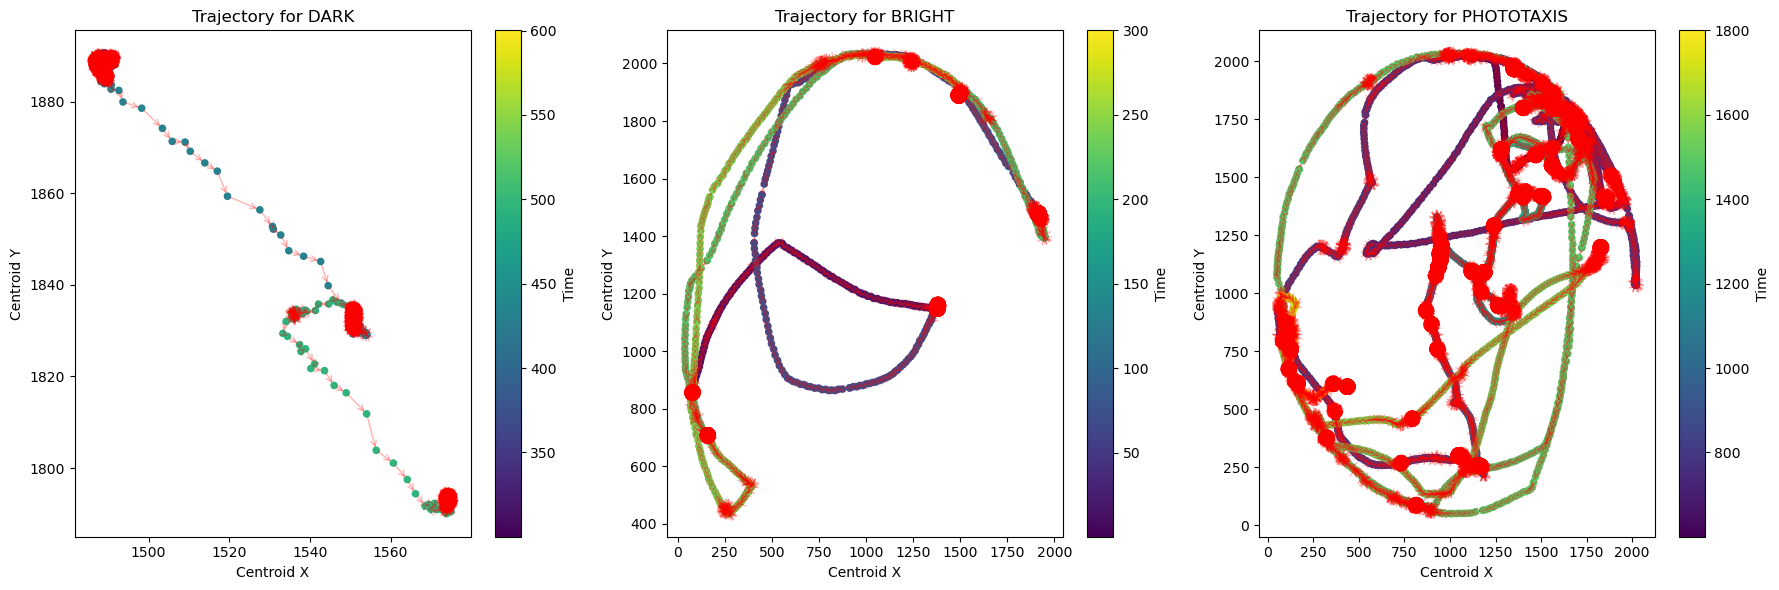

In [ ]:
def plot_fish_trajectories(data):
    # Create a figure with subplots for each stimulus type
    stim_types = [StimType.DARK, StimType.phototaxis, StimType.PHOTOTAXIS]
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, stim_type in enumerate(stim_types):
        # Filter data for specific stimulus type
        stim_data = data[data['stim_id'] == stim_type]
        
        # Create scatter plot with color gradient based on time
        scatter = axes[i].scatter(
            stim_data['centroid_x'], 
            stim_data['centroid_y'],
            c=stim_data['t_local'],  # Color based on time
            cmap='viridis',       # Color gradient
            s=20                  # Point size
        )
        
        # Add colorbar
        plt.colorbar(scatter, ax=axes[i], label='Time')
        
        # Set labels and title
        axes[i].set_title(f'Trajectory for {stim_type.name}')
        axes[i].set_xlabel('Centroid X')
        axes[i].set_ylabel('Centroid Y')
        
        # Optional: add arrows to show direction
        for j in range(len(stim_data)-1):
            axes[i].annotate('', 
                xy=(stim_data['centroid_x'].iloc[j+1], stim_data['centroid_y'].iloc[j+1]),
                xytext=(stim_data['centroid_x'].iloc[j], stim_data['centroid_y'].iloc[j]),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.3)
            )
    
    plt.tight_layout()
    plt.show()

# Assuming 'data' is your preprocessed DataFrame
plot_fish_trajectories(data_filtered)

In [ ]:
# def smooth_data_with_nans(speed_data, method='gaussian', **kwargs):
#     """
#     Apply smoothing to speed data that may contain NaN values
    
#     Parameters:
#     - speed_data: Series or array with speed values
#     - method: Smoothing method ('gaussian', 'moving_avg', or 'ewm')
#     - kwargs: Additional parameters for the chosen method
    
#     Returns:
#     - Smoothed data array
#     """
#     # Convert to pandas Series if not already
#     data = pd.Series(speed_data)
    
#     # First, get the indices of non-NaN values
#     valid_indices = ~data.isna()
    
#     if method == 'gaussian':
#         # Default parameters
#         sigma = kwargs.get('sigma', 2)
        
#         # Create a copy to avoid modifying the original
#         smoothed = data.copy()
        
#         # Apply Gaussian filter only to non-NaN values
#         if valid_indices.any():
#             # Fill NaNs temporarily with 0 for filtering
#             temp_data = data.fillna(0)
            
#             # Create a mask of valid values (1 for valid, 0 for NaN)
#             mask = valid_indices.astype(float)
            
#             # Apply Gaussian filter to data and mask
#             smoothed_data = gaussian_filter1d(temp_data.values, sigma=sigma)
#             smoothed_mask = gaussian_filter1d(mask.values, sigma=sigma)
            
#             # Divide filtered data by filtered mask where mask is not 0
#             with np.errstate(divide='ignore', invalid='ignore'):
#                 result = np.where(smoothed_mask > 1e-10, 
#                                  smoothed_data / smoothed_mask, 
#                                  np.nan)
            
#             # Update only previously valid points
#             smoothed.loc[valid_indices] = result[valid_indices]
        
#     elif method == 'moving_avg':
#         # Default parameters
#         window = kwargs.get('window', 15)
#         min_periods = kwargs.get('min_periods', 1)
        
#         # Apply rolling window average
#         smoothed = data.rolling(
#             window=window, 
#             center=True, 
#             min_periods=min_periods
#         ).mean()
        
#     elif method == 'ewm':
#         # Default parameters
#         span = kwargs.get('span', 10)
#         min_periods = kwargs.get('min_periods', 1)
        
#         # Apply exponentially weighted moving average
#         smoothed = data.ewm(
#             span=span, 
#             min_periods=min_periods
#         ).mean()
    
#     else:
#         raise ValueError(f"Unknown smoothing method: {method}")
        
#     return smoothed

# def detect_fish_bouts(data, fish_id=None):
#     """
#     Process fish movement data to detect swimming bouts
    
#     Parameters:
#     - data: DataFrame containing fish movement data
#     - fish_id: Optional ID for the fish (for plot titles)
    
#     Returns:
#     - Dictionary containing processed data and bout information
#     """
#     # Make a copy to avoid modifying the original data
#     df = data.reset_index(drop=True).copy()
    
#     smoothed_speed = smooth_data_with_nans(df['speed'], method='gaussian', sigma=2)
#     df['smoothed_speed'] = smoothed_speed
    
#     # Calculate threshold for bout detection
#     mean_speed = np.mean(smoothed_speed)
#     std_speed = np.std(smoothed_speed)
#     threshold = mean_speed + 2 * std_speed
    
#     # Find peaks in the smoothed data (potential bout centers)
#     peaks, peak_properties = find_peaks(
#         smoothed_speed, 
#         height=threshold,
#         distance=10,  # Minimum samples between peaks
#         prominence=0.5 * std_speed  # Minimum prominence to be considered a peak
#     )
    
#     # Find regions where speed exceeds threshold (bout regions)
#     bout_indices = np.where(smoothed_speed > threshold)[0]
    
#     # Group consecutive indices to identify complete bouts
#     bout_groups = []
#     for k, g in groupby(enumerate(bout_indices), lambda x: x[0] - x[1]):
#         group = list(map(itemgetter(1), g))
#         if len(group) > 3:  # Minimum number of frames to be considered a bout
#             bout_groups.append((group[0], group[-1]))
    
#     # Create a DataFrame to store bout information
#     bout_info = []
#     for i, (start_idx, end_idx) in enumerate(bout_groups):
#         # Find the peak within this bout
#         bout_peaks = [p for p in peaks if start_idx <= p <= end_idx]
        
#         if bout_peaks:
#             peak_idx = bout_peaks[np.argmax(smoothed_speed[bout_peaks])]
#             peak_speed = smoothed_speed[peak_idx]
            
#             # Calculate bout properties
#             bout_info.append({
#                 'bout_id': i+1,
#                 'start_idx': start_idx,
#                 'peak_idx': peak_idx,
#                 'end_idx': end_idx,
#                 'start_time': df['relative_time'].iloc[start_idx],
#                 'peak_time': df['relative_time'].iloc[peak_idx],
#                 'end_time': df['relative_time'].iloc[end_idx],
#                 'duration': df['relative_time'].iloc[end_idx] - df['relative_time'].iloc[start_idx],
#                 'peak_speed': peak_speed,
#                 'mean_speed': np.mean(smoothed_speed[start_idx:end_idx+1])
#             })
    
#     bout_df = pd.DataFrame(bout_info)
    
#     return {
#         'processed_data': df,
#         'smoothed_speed': smoothed_speed,
#         'threshold': threshold,
#         'peaks': peaks,
#         'bout_groups': bout_groups,
#         'bout_df': bout_df,
#         'fish_id': fish_id
#     }

# def plot_bout_detection(results):
#     """
#     Create plots to visualize the bout detection process
    
#     Parameters:
#     - results: Dictionary returned by detect_fish_bouts function
#     """
#     df = results['processed_data']
#     fish_id = results['fish_id']
#     smoothed_speed = results['smoothed_speed']
#     threshold = results['threshold']
#     peaks = results['peaks']
#     bout_groups = results['bout_groups']
    
#     # Create figure with 2 subplots
#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
#     # Plot 1: Original vs Smoothed Speed
#     ax1.plot(df['relative_time'], df['speed'], 'b-', alpha=0.5, label='Raw Speed')
#     ax1.plot(df['relative_time'], smoothed_speed, 'g-', linewidth=2, label='Smoothed Speed')
#     ax1.axhline(y=threshold, color='r', linestyle='--', alpha=0.7, label=f'Threshold ({threshold:.2f})')
#     ax1.set_ylabel('Speed (mm/sec)')
#     ax1.set_title(f'Original vs Smoothed Speed for Fish ID: {fish_id}')
#     ax1.legend()
#     ax1.grid(alpha=0.3)
    
#     # Plot 2: Detected Bouts
#     ax2.plot(df['relative_time'], smoothed_speed, 'g-', label='Smoothed Speed')
#     ax2.axhline(y=threshold, color='r', linestyle='--', alpha=0.7, label=f'Threshold ({threshold:.2f})')
    
#     # Highlight bout regions
#     for start_idx, end_idx in bout_groups:
#         start_time = df['relative_time'].iloc[start_idx]
#         end_time = df['relative_time'].iloc[end_idx]
#         ax2.axvspan(start_time, end_time, alpha=0.2, color='orange')
    
#     # Mark peak points
#     peak_times = df['relative_time'].iloc[peaks]
#     peak_speeds = smoothed_speed[peaks]
#     ax2.scatter(peak_times, peak_speeds, color='red', s=50, zorder=5, label='Bout Peaks')
    
#     ax2.set_xlabel('Relative Time')
#     ax2.set_ylabel('Speed (mm/sec)')
#     ax2.set_title(f'Detected Swimming Bouts for Fish ID: {fish_id}')
#     ax2.legend()
#     ax2.grid(alpha=0.3)
    
#     plt.tight_layout()
#     return fig

# def print_bout_statistics(results):
#     """
#     Print statistics about the detected bouts
    
#     Parameters:
#     - results: Dictionary returned by detect_fish_bouts function
#     """
#     bout_df = results['bout_df']
#     fish_id = results['fish_id']
    
#     print(f"\nBout Statistics for Fish ID: {fish_id}")
#     print(f"Total number of bouts detected: {len(bout_df)}")
    
#     if len(bout_df) > 0:
#         print(f"Average bout duration: {bout_df['duration'].mean():.2f} time units")
#         print(f"Average bout peak speed: {bout_df['peak_speed'].mean():.2f} mm/sec")
#         print(f"Average bout mean speed: {bout_df['mean_speed'].mean():.2f} mm/sec")
#         print("\nTop 5 bouts by peak speed:")
#         print(bout_df.sort_values('peak_speed', ascending=False).head(5)[['bout_id', 'start_time', 'duration', 'peak_speed']])